#Thanksgiving on Twitter#

[TEXT TEXT TEXT]

<img src="http://www.saveur.com/sites/saveur.com/files/import/2013/Feature-Thanksgiving-modern-classics-1200x800.jpg" width=640 height=480/>

<img src="http://a57.foxnews.com/global.fbnstatic.com/static/managed/img/fb2/news/876/493/black-friday-2012-1.jpg?ve=1&tl=1" width=640 height=480/>

In [8]:
%matplotlib inline
import re
import json
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
from datetime import datetime 
import pytz
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

#Table of Contents

* [Data](#Data)
    * [Scrape Tweets from Twitter API](#Scrape-Tweets-from-Twitter-API)
    * [Combine Twitter Data](#Combine-Twitter-Data)
    * [Clean Data](#Clean-Data)
        * [Spark Attempts to Clean Data](#Spark-Attempts-to-Clean-Data)
        * [Initial Data Cleaning in Pandas](#Initial-Data-Cleaning-in-Pandas)
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)
* [Analysis](#Analysis)
    * [Topic Analysis](#Topic-Analysis)
        * [Batch Variation Bayes for LDA](#Batch-Variation-Bayes-for-LDA)
            * [Algorithm Procedures: Batch Variation Bayes for LDA](#Algorithm-Procedures:-Batch-Variation-Bayes-for-LDA)
            * [Applying the tweets dataset on the Batch Variation Bayesian LDA](#Applying-the-tweets-dataset-on-the-Batch-Variation-Bayesian-LDA)
        * [Unsupervised Topic Extraction with LDA](#Unsupervised-Topic-Extraction-with-LDA)
            * [Creating the vocabulary](#Creating-the-vocabulary)
            * [Finding the natural number of topics](#Finding-the-natural-number-of-topics-for-Latent-Dirichlet-Allocationopics-to-fit-the-LDA-Model.)
            * [LDA Topic Interpretation](#LDA-Topic-Interpretation)
            * [Decide the topic of each tweet](#Decide-the-topic-of-each-tweet)
    * [Sentiment Analysis](#Sentiment-Analysis)
        * [Sentiment Analysis using Word Match](#Sentiment-Analysis-using-Word-Match)
        * [Sentiment Analysis using Pattern](#Sentiment-Analysis-using-Pattern)

#Data

## Scrape Tweets from Twitter API

[TEXT TEXT TEXT: processes of obtaining twitter data.
Time, location and other specifications for data extraction]

In [9]:
import time, sys, tweepy
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

In [ ]:
"""
Class
--------
JSONListener

This class is a wrap up for StreamListener to handles tweets are the 
received from the stream.
This is a basic listener that just prints received tweets to stdout.
    
Parameters
----------
max_tweet: the maximum number of tweets the listener will receive.
output folder: assign the value to designate the output folder for all json files.


Output
---------
The class receives data from StreamListener and store them to the designated folder, 
with filename the time the listerner starts
"""


#[NEED TO UPDATE WITH THE ACTUAL CODE]
# Go to http://dev.twitter.com and create an app.
# The consumer key and secret will be generated for you after
consumer_key="fyeZKOx2yQorVWIeir6Iefvzd"
consumer_secret="96eaL995tWhqyN2mjdT8IHqK6AEzvcn1qJAaSbjzw62TP5uaxO"

# After the step above, you will be redirected to your app's page.
# Create an access token under the the "Your access token" section
access_token="273534302-uY6aKA3iz9KTTgHsGBPEKln188FKocOfikAnbyuE"
access_token_secret="OfT42aA94rWPec1bqokFR7VygPu8QO6wv1Rdf25sOlKhO"

# List of cities: the numbers are the centers of each city, with square -/+ 0.2
location_list = {'Harvard University, Cambridge' : [-71.1211537 - 0.3, 42.3735321 - 0.3, -71.1211537 + 0.3, 42.3735321 + 0.3]}

class JSONListener(StreamListener):

    def __init__(self, fprefix = 'streamer', max_tweets = 5):
        self.counter = 0
        self.fprefix = fprefix
        self.output  = open('../../../Desktop/109data/' + fprefix + '.json', 'wb')
        self.max_tweets = max_tweets
        
    def on_data(self, data):
        if self.counter < self.max_tweets:
            data = data.encode("UTF-8")
            self.output.write(data)
            self.counter += 1

            # Print the information
            status = json.loads(data)
            print '{} Tweets at [Time = {}]'.format(self.counter, status['created_at'])
            return True
        else:
            self.output.close()
            print 'Totally {} tweets collected'.format(self.max_tweets)
            return False
        

        
    def on_error(self, status):
        print 'Error: ' + str(status)

if __name__ == '__main__':
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    # Set Track
    count = 0
    while True:
        listen = JSONListener(fprefix = time.strftime("%d-%m-%Y %H-%M-%S"), max_tweets = 1000)

        stream = Stream(auth, listen)

        start = time.time()
        stream.filter(locations = location_list['Harvard University, Cambridge'], track=['#ECEupgrade'])

        print 'Job completed. Disconnecting stream...'
        print 'Total Time:', time.time() - start

        stream.disconnect()
        count += 1

##Combine Twitter Data

After extracting daily tweets into json files, we need to combine all the json files to a master pool.

In [10]:
"""
The codes below combines all output files gathered by streaming API to a single list 'tweets_data'

Each element in 'tweets_data' contains all the infomation of a single tweet.
"""

import os
tweets_data = []

for data_file_name in os.listdir("raw_data/data/"):
    if data_file_name.endswith(".json"): 
        print data_file_name
        tweets_file = open("raw_data/data/" + data_file_name, "r")
        for line in tweets_file:
            try:
                tweet = json.loads(line)
                tweets_data.append(tweet)
            except:
                continue

23-11-2015 14-06-45.json
23-11-2015 14-39-39.json
23-11-2015 15-12-15.json
23-11-2015 15-47-06.json
23-11-2015 16-19-42.json
23-11-2015 16-51-46.json
23-11-2015 17-24-58.json
23-11-2015 18-00-14.json
23-11-2015 18-33-39.json
23-11-2015 19-05-07.json
23-11-2015 19-36-23.json
23-11-2015 20-03-18.json
23-11-2015 20-27-45.json
23-11-2015 20-49-59.json
23-11-2015 21-12-17.json
23-11-2015 21-33-44.json
23-11-2015 21-52-59.json
23-11-2015 22-10-56.json
23-11-2015 22-25-12.json
23-11-2015 22-41-59.json
23-11-2015 23-01-48.json
23-11-2015 23-20-52.json
23-11-2015 23-48-50.json
24-11-2015 00-09-24.json
24-11-2015 00-50-10.json
24-11-2015 02-07-11.json
24-11-2015 06-02-57.json
24-11-2015 07-35-13.json
24-11-2015 08-34-07.json
24-11-2015 09-20-45.json
24-11-2015 10-00-36.json
24-11-2015 10-41-10.json
24-11-2015 11-19-21.json
24-11-2015 11-54-24.json
24-11-2015 12-27-24.json
24-11-2015 21-57-26.json
24-11-2015 22-27-47.json
24-11-2015 23-01-56.json
24-11-2015 23-39-44.json
25-11-2015 00-29-57.json


In [11]:
print 'Number of tweets in total: ', len(tweets_data)

Number of tweets in total:  0


##Clean Data

[CHANGE SO IT MATCHES DATAFRAME]

Each tweet have many features, and we focus on the following features:
    - user id: the user's tweeter id
    - followers_count: the number of followers
    - friends_count: the number of people the user is following
    - statuses_count: the number of status tweets sent in the past
    - created_at_u: time the user account is created
    - admin_place: the place where the account is created? $$$DIDN'T FIND THIS COLUMN$$$
    
    - created_at_t: time the tweet is created
    - id: tweet's ide
    - text: the content of the tweet
    - truncated: (boolean) whether the text is truncated or not.
    - in_reply_to_status_id: whether the tweet is a reply ???
    - retweeted_status: True if the tweet is a retweet
    - lang: language of the text
    - timestamp_ms: when the tweet is created.
    
    - place.full_name: location of tweets if geo enabled
    - quoted_status.text: text of quoted tweet
    
[IS THIS TRUE?]Notice that if it is a retweet, the text of previous tweet will be embeded in the `text`. Thus we use `retweeted_status` as an indicator of whether further parsing is needed.


In [96]:
"""
Function
--------
getCoords

Get the longitude and latitude where the tweets were sent by computing the average boundaries

Parameters
----------
tweet: one single tweet infomation extracted from tweets dataframe
coord_type: mark the type of coordinate, 0 for longitude and 1 for latitude

Output: either average longitude or latitude depending on coord_type
"""

def getCoords(tweet, coord_type):
    if tweet['place'] is None:
        return None;
    coord = tweet['place']['bounding_box']['coordinates'][0]
    result = []
    for i in range(len(coord)):
        result.append(coord[i][coord_type])
    return np.mean(result)




With tweets_data read from previous section, we are able to generate a raw dataframe containing all the tweets and use it for all future data cleaning and analysis.

Here we also convert timestamp to Boston local time and computed tweet coordinate using getCoords function defined above.

In [7]:
from datetime import datetime
from pytz import timezone
eastern = timezone('US/Eastern')

In [ ]:

"""
Note:

In this section of codes, two parts worthing noticing:

1) Call datetime.fromtimestamp()
Process timestamp to extract date and time according to local Boston time zone

2) Call getCoords(tweet, coord_type)
compute average longitude and latitude of the tweet

"""

tweets = pd.DataFrame()
tweets['user_id'] = map(lambda tweet: tweet['user']['id'], tweets_data)
tweets['date'] = map(lambda tweet: datetime.fromtimestamp(float(tweet['timestamp_ms'])/1000.0, tz = eastern).date().strftime("%Y-%m-%d"), tweets_data)
tweets['time'] = map(lambda tweet: datetime.fromtimestamp(float(tweet['timestamp_ms'])/1000.0, tz = eastern).time().strftime("%H:%M:%S"), tweets_data)
tweets['tweet_longitude'] = map(lambda tweet: getCoords(tweet, 0), tweets_data)
tweets['tweet_latitude'] = map(lambda tweet: getCoords(tweet, 1), tweets_data)
tweets['tweet_id'] = map(lambda tweet: tweet['id'], tweets_data)
tweets['text'] = map(lambda tweet: tweet['text'], tweets_data)
tweets['followers_count'] = map(lambda tweet: tweet['user']['followers_count'], tweets_data)
tweets['friends_count'] = map(lambda tweet: tweet['user']['friends_count'], tweets_data)
tweets['statuses_count'] = map(lambda tweet: tweet['user']['statuses_count'], tweets_data)
tweets['created_at_u'] = map(lambda tweet: tweet['user']['created_at'], tweets_data)
tweets['truncated'] = map(lambda tweet: tweet['truncated'], tweets_data)
tweets['quoted_text'] = map(lambda tweet: tweet['quoted_status']['text'] if (tweet['is_quote_status'] == True) & ('quoted_status' in tweet.keys()) else None, tweets_data)
tweets['in_reply_to_status_id'] = map(lambda tweet: tweet['in_reply_to_status_id'], tweets_data)
tweets['retweeted_status'] = map(lambda tweet: tweet['retweeted_status'] if 'retweeted_status' in tweet.keys() else None, tweets_data)
tweets['timestamp_ms'] = map(lambda tweet: tweet['timestamp_ms'], tweets_data)
tweets['lang'] = map(lambda tweet: tweet['lang'], tweets_data)
tweets['country'] = map(lambda tweet: tweet['place']['country'] if tweet['place'] != None else None, tweets_data)
tweets['place_full_name'] = map(lambda tweet: tweet['place']['full_name'] if tweet['place'] != None else None, tweets_data)


Clean NaN values:

In [ ]:
tweets.loc[tweets.quoted_text.isnull(),'quoted_text'] = None
tweets.loc[tweets.in_reply_to_status_id.isnull(),'in_reply_to_status_id'] = 0
tweets.loc[tweets.retweeted_status.isnull(),'retweeted_status'] = False

And finally we save it. This ends the initial data gathering and combining part of the project. Save the csv file, store it somewhere safe first. Later we start from reading the csv file every time we reopen the notebook.

In [ ]:
tweets.to_csv("raw_data/dftweets.csv", index = False, encoding='utf-8')

In [12]:
dftouse=pd.read_csv("raw_data/dftweets.csv")
dftouse.head()

//anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (0,4,5,8,11,14) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


,user_id,date,time,tweet_longitude,tweet_latitude,tweet_id,text,followers_count,friends_count,statuses_count,created_at_u,truncated,quoted_text,in_reply_to_status_id,retweeted_status,timestamp_ms,lang,country,place_full_name
0,3095695629,2015-11-23,14:06:44,-71.683502,42.0369325,668868299040665603,@DopeAhhAquarius lemme come over bro :(,7424,985,36984,Thu Mar 19 01:33:34 +0000 2015,False,NaN,6.688680e+17,False,1.448306e+12,en,United States,"Massachusetts, USA"
1,2174756318,2015-11-23,14:06:44,-71.326858,42.636248,668868299116138496,I've been in a bad mood since like 2010,110,159,2199,Mon Nov 04 21:06:33 +0000 2013,False,NaN,0.000000e+00,False,1.448306e+12,en,United States,"Lowell, MA"
2,408976087,2015-11-23,14:06:46,-71.088755,42.3136695,668868309526429697,what's the appropriate age for me to start act...,514,246,37162,Thu Nov 10 03:50:52 +0000 2011,False,NaN,0.000000e+00,False,1.448306e+12,en,United States,"Boston, MA"
3,1163319366,2015-11-23,14:06:52,-71.312617,42.6931085,668868335573012480,@JackSillin @AlexReedWX @WesternMEwx ...I assu...,465,604,57037,Sat Feb 09 16:02:36 +0000 2013,False,NaN,6.688683e+17,False,1.448306e+12,en,United States,"Dracut, MA"
4,1600099118,2015-11-23,14:06:53,-96.307306,65.8381145,668868340136484864,https://t.co/pEaLZwrJpj https://t.co/MZKFV7H10o,3,43,26716,Wed Jul 17 05:04:16 +0000 2013,False,NaN,0.000000e+00,False,1.448306e+12,und,Canada,Canada


###Sanity Check Data###
There might be corrupted data during the process of extracting and dumping, and we want to see the frequency and impact of these corrupted records. We found that there are only 2 records that look corrupted, and therefore remove them from the dataframe we work with.

In [13]:
dftouse.isnull().sum()

user_id                       0
date                          0
time                          0
tweet_longitude              78
tweet_latitude               78
tweet_id                      0
text                          2
followers_count               2
friends_count                 2
statuses_count                2
created_at_u                  2
truncated                     2
quoted_text              154439
in_reply_to_status_id         4
retweeted_status              4
timestamp_ms                  4
lang                          4
country                      82
place_full_name              82
dtype: int64

We expect to see lots of NaN's for quoted_text or country/place, as not all tweets contain that data. However, there seems to be two tweets that are missing lots of fields:

In [15]:
dftouse[dftouse.tweet_id.isnull()]

,user_id,date,time,tweet_longitude,tweet_latitude,tweet_id,text,followers_count,friends_count,statuses_count,created_at_u,truncated,quoted_text,in_reply_to_status_id,retweeted_status,timestamp_ms,lang,country,place_full_name


Therefore, we decide to remove these two tweets from our dataframe, along with the tweets that are missing geographical information, because most of our analyses involves geographical variance. Also, we remove all tweets that are not in English, as we won't be able to accurately classify topics and sentiments for these tweets.

In [16]:
dftouse["lang"].value_counts()

en     138468
und     18152
es       2705
fr       1590
pt       1287
tl        755
ar        696
in        464
de        323
it        264
tr        199
et        198
ro        188
ja        167
nl        158
no        150
da        129
sv        127
pl        117
ne         75
zh         74
bs         69
ru         69
th         58
fi         52
sl         51
hi         47
sk         43
lv         40
hu         36
is         33
lt         33
el         33
hr         29
fa         22
ko         15
iw          9
bg          6
ur          6
vi          2
uk          1
te          1
dtype: int64

In [17]:
dftouse = dftouse[dftouse.tweet_id.notnull() & dftouse.place_full_name.notnull()]
dftouse = dftouse[dftouse.lang == "en"]
#dftouse.isnull().sum()

###Spark Attempts to Clean Data###

Initially, we tried reading in and cleaning data in Spark, because SPARK SQL gives very clean and nice functionalities for showing multi-layer data. We were successful for individual datasets but failed on the combined data. The problem arises when we are trying to use SPARK SQL to read the whole tweet data, and there is memory issues potentially due to the large data size. 

Therefore, we did our initial data cleaning using Pandas, and then convert the dataframe into Spark dataframe for natural language processing.

In [ ]:
# Read in json file: (create a list of tweets)
# with open("raw_data/pre-thanksgiving data/26-11-2015 10-19-06.json") as json_file:    
import os
with open('raw_data/combined.json', 'w') as fp:
    for data_file_name in os.listdir("raw_data/pre-thanksgiving data/"):
        if data_file_name.endswith(".json"): 
            for line in open("raw_data/pre-thanksgiving data/"+data_file_name):
                json.dump(line, fp)

In [ ]:
# tweetdf = sqlsc.read.json("raw_data/combined.json")
tweetdfspark = sqlsc.read.json("raw_data/pre-thanksgiving data/26-11-2015 10-19-06.json")
#tweetdf.show(5)

In [5]:
# We cache the data to make sure it is only read once from disk
tweetdf.cache()
print "How many tweets do we have?", tweetdf.count()
# Then we use printSchema to lay out the structure of the tweet data
tweetdf.printSchema()

How many tweets do we have? 1000
root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- e

One of the key challenges in data cleaning on tweets is that the desired variables are usually sub-attributes that are a few layers nested inside different categories.

Our solution is to use Spark SQL, which allows us to use SQL-like queries to select, filter and aggregate the Spark Dataframe.
http://spark.apache.org/docs/latest/sql-programming-guide.html



In [6]:
# Create temporary table for SQL queries
tweetdf.registerTempTable("tweetdf") 
dftouse = sqlsc.sql("SELECT user.id as uid, user.location as location_u, user.followers_count, user.friends_count, user.statuses_count, user.created_at as created_at_u, created_at as created_at_t, id as tid, text, truncated, in_reply_to_status_id, retweeted, quoted_status.text as quote_text, lang, timestamp_ms, place.full_name as location_t FROM tweetdf")

In [7]:
dftouse.take(3)

[Row(uid=1652821, location_u=u'boston, ma', followers_count=2060, friends_count=1508, statuses_count=38508, created_at_u=u'Tue Mar 20 17:49:39 +0000 2007', created_at_t=u'Thu Nov 26 15:19:08 +0000 2015', tid=669898187356954624, text=u'That was quick https://t.co/te2gtFO47Q', truncated=False, in_reply_to_status_id=None, retweeted=False, quote_text=u'It hasnt taken long for community members to make #PiZero #RaspberryPi cases for #3DPrinting https://t.co/3FbnFwEcpv https://t.co/OrUCPjNhDM', lang=u'en', timestamp_ms=u'1448551148629', location_t=u'Lowell, MA'),
 Row(uid=96374440, location_u=u'Springfield, MA', followers_count=1225, friends_count=1686, statuses_count=28033, created_at_u=u'Sat Dec 12 16:43:59 +0000 2009', created_at_t=u'Thu Nov 26 15:19:10 +0000 2015', tid=669898193425948672, text=u"First legal drink with my little sister last night #ThanksgivingEve #tobysilovethisbar @ Toby Keith's\u2026 https://t.co/sfo45GwihA", truncated=False, in_reply_to_status_id=None, retweeted=False,

In [320]:
# Clean some variables to usable formats as needed
import datetime
starttime = datetime.datetime(1970,1,1,0,0,0)
def clean_df((uid, location_u, followers_count, friends_count, statuses_count, created_at_u, created_at_t, tid, text, truncated, in_reply_to_status_id, retweeted, quote_text, lang, timestamp_ms, location_t)):
# Date and Time of Tweet
    timestamp = starttime + datetime.timedelta(milliseconds = int(timestamp_ms))
    #add date variable --- J#
    date=timestamp.date()
    return uid, location_u, followers_count, friends_count, statuses_count, created_at_u, created_at_t, tid, text, truncated, in_reply_to_status_id, retweeted, quote_text, lang, timestamp, location_t, date

In [321]:
dftouse1 = dftouse.map(clean_df)
dftouse1.take(1)

[(1652821,
  u'boston, ma',
  2060,
  1508,
  38508,
  u'Tue Mar 20 17:49:39 +0000 2007',
  u'Thu Nov 26 15:19:08 +0000 2015',
  669898187356954624,
  u'That was quick https://t.co/te2gtFO47Q',
  False,
  None,
  False,
  u'It hasnt taken long for community members to make #PiZero #RaspberryPi cases for #3DPrinting https://t.co/3FbnFwEcpv https://t.co/OrUCPjNhDM',
  u'en',
  datetime.datetime(2015, 11, 26, 15, 19, 8, 629000),
  u'Lowell, MA',
  datetime.date(2015, 11, 26))]

<img src="https://media.giphy.com/media/9Y5BbDSkSTiY8/giphy.gif">
####---end of the failed attempt---###


###Initial Data Cleaning in Pandas

#####1. Clean Date and Timestamp
#####(This has already been down in Clean Data section, consider removing this part...)
*Note: Already modified this part and get job done in the dataframe initiation stage...*


Use microsecond variable to compute the exact timestamp for each tweet.

In [5]:
import datetime
starttime = datetime.datetime(1970,1,1,0,0,0)
def clean_df(time_ms):
    timestamp = starttime + datetime.timedelta(milliseconds = int(time_ms))
    return timestamp
dftouse['timestamp'] = dftouse['timestamp_ms'].apply(clean_df)
dftouse['date'] = dftouse['timestamp'].apply(lambda r: r.date())

In [9]:
dftouse.to_csv("raw_data/dftweet_datetime.csv", index = False)

In [19]:
len(dftouse)

138396

#####2. Clean Hashtags

Beause thanksgiving and shopping may be quoted in different formats in hashtags, we use regular expression to identify hashtags about thanksgiving and shopping. And we define a function `regreform` to formate hashtag texts. We lemmatize other words by using `gensim` package.

Note that lemmatization is type of normalization that treats different inflected forms of a word as a single unit ("work", "working", "works", "worked", "working" => same lemma: "work"):
         

In [20]:
#keywords
thxgiving=[r'[\w_]giving',r'turkey']
giving_re = re.compile(r'('+'|'.join(thxgiving)+')', re.VERBOSE | re.IGNORECASE)
shopping=[r'macys',
          r'shop',
          r'nordstrom',
          r'amazon',
          r'blackfriday',
          r'bloomingdales',
          r'bestbuy',
          r'target',
          r'cybermonday',
          r'[\w_]sale']
shop_re=re.compile(r'('+'|'.join(shopping)+')', re.VERBOSE | re.IGNORECASE)

In [21]:
import gensim
"""
Function
--------
regreform

Reformate hashtags extracted from text and quoted text

Parameters
----------
textlist : a list of hashtag texts.

Output: a list of reformatted hashtags
"""


def regreform(textlist):
    tokens=set()

    for token in textlist:
        
        #add thanksgiving/NN to token list if textlist have 
        #mentioned thanksgiving
        if giving_re.search(token):
            tokens.add('thanksgiving/NN')
            if shop_re.search(token):
                tokens.add('shopping/NN')
        
        #add shopping/NN to token list if textlist have 
        #mentioned shopping
        elif shop_re.search(token):
            tokens.add('shopping/NN')
        else:
            
        #lemmatize other words
            t=gensim.utils.lemmatize(token)
            if len(t)>0:
                tokens.add(t[0])
            else:
                tokens.add(token)
    
    return list(tokens)

####3. Extract hashtags, emoticons, and emoji

Emoticons and emoji are quite popular, and people tend to include them in their tweets. In particular, emoji is very useful for our analysis. For example, 📀 refers DVD. If we are able to replace emoji with the items they represent, we will obtain more information about a tweet.

We found a emoji list with explanation for each emoji [here](http://ftp.unicode.org/Public/emoji/1.0/emoji-data.txt), and we use it to create a emoji dictionary.

In [22]:
#'http://ftp.unicode.org/Public/emoji/1.0/emoji-data.txt'
f = open('raw_data/emoji-data.txt','r');
mapping = {};
for line in f:
    line = line.decode('utf-8')
    line=re.sub('\(',";",line)
    line=re.sub('\)',";",line)
    linelist=line.split(';')
    mapping[linelist[5]] = linelist[6].strip()
f.close;

In [23]:
mapping

{u'\U0001f475': u'OLDER WOMAN',
 u'\U0001f474': u'OLDER MAN',
 u'\U0001f477': u'CONSTRUCTION WORKER',
 u'\U0001f31d': u'FULL MOON WITH FACE',
 u'\U0001f471': u'PERSON WITH BLOND HAIR',
 u'\u2604': u'COMET',
 u'\U0001f473': u'MAN WITH TURBAN',
 u'\U0001f472': u'MAN WITH GUA PI MAO',
 u'\U0001f47d': u'EXTRATERRESTRIAL ALIEN',
 u'\U0001f47c': u'BABY ANGEL',
 u'\U0001f47f': u'IMP',
 u'\u270a': u'RAISED FIST',
 u'\U0001f479': u'JAPANESE OGRE',
 u'\U0001f478': u'PRINCESS',
 u'\U0001f47b': u'GHOST',
 u'\U0001f47a': u'JAPANESE GOBLIN',
 u'\U0001f465': u'BUSTS IN SILHOUETTE',
 u'\U0001f464': u'BUST IN SILHOUETTE',
 u'\U0001f467': u'GIRL',
 u'\U0001f466': u'BOY',
 u'\u2795': u'HEAVY PLUS SIGN',
 u'\u2614': u'UMBRELLA WITH RAIN DROPS',
 u'\u3297': u'CIRCLED IDEOGRAPH CONGRATULATION',
 u'\U0001f462': u'WOMANS BOOTS',
 u'\U0001f46d': u'TWO WOMEN HOLDING HANDS',
 u'\U0001f46c': u'TWO MEN HOLDING HANDS',
 u'\U0001f46f': u'WOMAN WITH BUNNY EARS',
 u'\U0001f46e': u'POLICE OFFICER',
 u'\U0001f469': u'WO

In [24]:
#source: http://marcobonzanini.com/2015/03/09/mining-twitter-data-with-python-part-2/
    
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\[/\\OpP] # Mouth
    )"""

#we are not interested in url, and @ mentions

hash_tags= r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)"

html=r'<[^>]+>'

url=r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+'

mention=r'(?:@[?\w_]+)'

regex1=r"\.{2,}"

regex2=r"\-{2,}"

#emoji
try:
    # UCS-4
    emoji_re = re.compile(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])')
except re.error:
    # UCS-2
    emoji_re = re.compile(u'([\u2600-\u27BF])|([\uD83C][\uDF00-\uDFFF])|([\uD83D][\uDC00-\uDE4F])|([\uD83D][\uDE80-\uDEFF])')


regex_str = [
    emoticons_str,
    html, # HTML tags
    mention, # @-mentions
    hash_tags, # hash-tags
    url, # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    regex1,
    regex2,
    r'(?:\S)' # anything else
]


remove_str=[
    emoticons_str,
    html, # HTML tags
    mention, # @-mentions ????
    url, # URLs
    regex1,
    regex2,
]
    

tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
remove_re = re.compile(r'('+'|'.join(remove_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
hash_tags_re = re.compile(hash_tags, re.VERBOSE | re.IGNORECASE)
   

In [25]:
"""
Function
--------
tokenize

Convert text to tokens, if the text has emoji,
convert emoji to text using `mapping`, and save as a list.

Parameters
----------
s: text

Output
---------
tokens: tokens of a text, including emoji 
emojitext: list of texts represented by emoji
"""

def tokenize(s):
    emojitext=set([])
    #find all emoji
    for utuple in emoji_re.findall(s):
        for i in utuple:
            if len(i)>0:
                try:
    #use the emoji dictionary to find what the emoji represent
                    emojitext.add(mapping[i])
                except KeyError:
                    continue
    
    #find all tokens
    tokens=tokens_re.findall(s)
    
    if len(emojitext)>0:
        tokens=tokens+(list(emojitext))
    
    return tokens,list(emojitext)

In [26]:
"""
Function
--------
preprocess

Combine text and quoted_text to one,
Remove url, html tag, @-mentions from the combined text,
Extract hashtags  and emoticons from the combined text.

Parameters
----------
s: text

Output
---------
s: return a string without url, html tag, and @-mentions
s_tokens: return a list of tokens
emoticons: return a list of emoticons
hashtags: return a list of hashtags
"""

def preprocess(s):
        s=s.decode('utf-8')
        tokens,emoji = tokenize(s)
        #get the lower case
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
        
        #get the list of emoticons
        emo= filter(None,[token if emoticon_re.search(token) else None for token in tokens])
        
        #get the list of hashtags
        ht=filter(None,[token[1:] if hash_tags_re.search(token) else None for token in tokens])
        hashtags = regreform(ht)    
        
        #remove @ and html tag, url, emoticons_str,emoji
        s_clean=emoji_re.sub(',',s)
        s_clean=remove_re.sub('',s_clean)
        
        #add the list of texts represented by emoji to clean text
        emoji.append(s_clean)
        s_clean='.'.join(emoji)
        t_c,e_c = tokenize(s_clean)
        s_tokens = [token.lower() for token in t_c]
        return s_clean, s_tokens,emo,hashtags

In [58]:
dftokens=dftouse.reset_index()

dftokens['sent']=dftokens['text'].apply(lambda r: preprocess(r) if (len(str(r))>0) & (isinstance(r, str)) else '' )
#dftokens.take(2)
dftokens.head()

,index,user_id,date,time,tweet_longitude,tweet_latitude,tweet_id,text,followers_count,friends_count,statuses_count,created_at_u,truncated,quoted_text,in_reply_to_status_id,retweeted_status,timestamp_ms,lang,country,place_full_name,sent
0,0,3095695629,2015-11-23,14:06:44,-71.683502,42.0369325,668868299040665603,@DopeAhhAquarius lemme come over bro :(,7424,985,36984,Thu Mar 19 01:33:34 +0000 2015,False,NaN,6.688680e+17,False,1.448306e+12,en,United States,"Massachusetts, USA","( lemme come over bro , [lemme, come, over, br..."
1,1,2174756318,2015-11-23,14:06:44,-71.326858,42.636248,668868299116138496,I've been in a bad mood since like 2010,110,159,2199,Mon Nov 04 21:06:33 +0000 2013,False,NaN,0.000000e+00,False,1.448306e+12,en,United States,"Lowell, MA","(I've been in a bad mood since like 2010, [i'v..."
2,2,408976087,2015-11-23,14:06:46,-71.088755,42.3136695,668868309526429697,what's the appropriate age for me to start act...,514,246,37162,Thu Nov 10 03:50:52 +0000 2011,False,NaN,0.000000e+00,False,1.448306e+12,en,United States,"Boston, MA",(what's the appropriate age for me to start ac...
3,3,1163319366,2015-11-23,14:06:52,-71.312617,42.6931085,668868335573012480,@JackSillin @AlexReedWX @WesternMEwx ...I assu...,465,604,57037,Sat Feb 09 16:02:36 +0000 2013,False,NaN,6.688683e+17,False,1.448306e+12,en,United States,"Dracut, MA","( I assume your dad works at your school?), ..."
4,6,107886768,2015-11-23,14:06:55,-96.307306,65.8381145,668868346813771776,"@kady I'm watching River (BBC) on netflix, I t...",961,1198,85936,Sun Jan 24 03:02:09 +0000 2010,False,NaN,0.000000e+00,False,1.448306e+12,en,Canada,Canada,"( I'm watching River (BBC) on netflix, I think..."


Update the dataframe to store hashtag tokens and emoticans separately.

In [59]:
splitcol = lambda x: pd.Series([i for i in x])
text_s = dftokens['sent'].apply(splitcol)
text_s.rename(columns={0:'s_clean',1:'s_tokens',2:'s_emo',3:'s_hashtags'},inplace=True)
text_s.head()

,s_clean,s_tokens,s_emo,s_hashtags
0,lemme come over bro,"[lemme, come, over, bro]",[:(],[]
1,I've been in a bad mood since like 2010,"[i've, been, in, a, bad, mood, since, like, 2010]",[],[]
2,what's the appropriate age for me to start act...,"[what's, the, appropriate, age, for, me, to, s...",[],[]
3,I assume your dad works at your school?),"[i, assume, your, dad, works, at, your, school...",[],[]
4,"I'm watching River (BBC) on netflix, I think ...","[i'm, watching, river, (, bbc, ), on, netflix,...",[],[]


In [74]:
dftokens['quoted']=dftokens['quoted_text'].apply(lambda r: preprocess(r) if (len(str(r))>0) & (isinstance(r, str)) else '' )
dftokens.take(2)
text_q = dftokens['quoted'].apply(splitcol)
text_q.rename(columns={0:'q_clean',1:'q_tokens',2:'q_emo',3:'q_hashtags'},inplace=True)

In [ ]:
dftokens1 = pd.concat([dftokens, text_s, text_q], axis=1)


Change NaNs to meaningful representation:

In [62]:
dftokens1.to_csv("raw_data/dftokens.csv", index = False, encoding='utf-8')
#dftokens.to_json("raw_data/dftokens.json")

In [72]:
dftokens=pd.read_csv("raw_data/dftokens.csv")

dftokens.loc[dftokens.q_clean.isnull(),'q_clean'] = ''
dftokens['cleaned_text'] = dftokens['s_clean'] + dftokens['q_clean']
dftokens.head()

,index,user_id,date,time,tweet_longitude,tweet_latitude,tweet_id,text,followers_count,friends_count,statuses_count,created_at_u,truncated,quoted_text,in_reply_to_status_id,retweeted_status,timestamp_ms,lang,country,place_full_name,sent,quoted,s_clean,s_tokens,s_emo,s_hashtags,q_clean,q_tokens,q_emo,q_hashtags,cleaned_text
0,0,3095695629,2015-11-23,14:06:44,-71.683502,42.036932,668868299040665603,@DopeAhhAquarius lemme come over bro :(,7424,985,36984,Thu Mar 19 01:33:34 +0000 2015,False,NaN,6.688680e+17,False,1.448306e+12,en,United States,"Massachusetts, USA","( lemme come over bro , [lemme, come, over, br...",NaN,lemme come over bro,"[lemme, come, over, bro]",[:(],[],,NaN,NaN,NaN,lemme come over bro
1,1,2174756318,2015-11-23,14:06:44,-71.326858,42.636248,668868299116138496,I've been in a bad mood since like 2010,110,159,2199,Mon Nov 04 21:06:33 +0000 2013,False,NaN,0.000000e+00,False,1.448306e+12,en,United States,"Lowell, MA","(I've been in a bad mood since like 2010, [i'v...",NaN,I've been in a bad mood since like 2010,"[i've, been, in, a, bad, mood, since, like, 2010]",[],[],,NaN,NaN,NaN,I've been in a bad mood since like 2010
2,2,408976087,2015-11-23,14:06:46,-71.088755,42.313670,668868309526429697,what's the appropriate age for me to start act...,514,246,37162,Thu Nov 10 03:50:52 +0000 2011,False,NaN,0.000000e+00,False,1.448306e+12,en,United States,"Boston, MA",(what's the appropriate age for me to start ac...,NaN,what's the appropriate age for me to start act...,"[what's, the, appropriate, age, for, me, to, s...",[],[],,NaN,NaN,NaN,what's the appropriate age for me to start act...
3,3,1163319366,2015-11-23,14:06:52,-71.312617,42.693109,668868335573012480,@JackSillin @AlexReedWX @WesternMEwx ...I assu...,465,604,57037,Sat Feb 09 16:02:36 +0000 2013,False,NaN,6.688683e+17,False,1.448306e+12,en,United States,"Dracut, MA","( I assume your dad works at your school?), ...",NaN,I assume your dad works at your school?),"[i, assume, your, dad, works, at, your, school...",[],[],,NaN,NaN,NaN,I assume your dad works at your school?)
4,6,107886768,2015-11-23,14:06:55,-96.307306,65.838115,668868346813771776,"@kady I'm watching River (BBC) on netflix, I t...",961,1198,85936,Sun Jan 24 03:02:09 +0000 2010,False,NaN,0.000000e+00,False,1.448306e+12,en,Canada,Canada,"( I'm watching River (BBC) on netflix, I think...",NaN,"I'm watching River (BBC) on netflix, I think ...","[i'm, watching, river, (, bbc, ), on, netflix,...",[],[],,NaN,NaN,NaN,"I'm watching River (BBC) on netflix, I think ..."


Check how many tweets are quoted:

In [75]:
dftokens[~dftokens.quoted_text.isnull()]

,index,user_id,date,time,tweet_longitude,tweet_latitude,tweet_id,text,followers_count,friends_count,statuses_count,created_at_u,truncated,quoted_text,in_reply_to_status_id,retweeted_status,timestamp_ms,lang,country,place_full_name,sent,quoted,s_clean,s_tokens,s_emo,s_hashtags,q_clean,q_tokens,q_emo,q_hashtags,cleaned_text
7,12,4204521803,2015-11-23,14:07:08,-71.196239,42.181867,668868402170175488,"No, seasons change, people don't https://t.co/...",20,67,153,Mon Nov 16 20:40:37 +0000 2015,False,"Love is rare, Life is strange, Nothing last, p...",0,False,1.448306e+12,en,United States,"Norwood, MA","(No, seasons change, people don't , [no, ,, se...","(Love is rare, Life is strange, Nothing last, ...","No, seasons change, people don't","[no, ,, seasons, change, ,, people, don't]",[],[],"Love is rare, Life is strange, Nothing last, p...","[love, is, rare, ,, life, is, strange, ,, noth...",[],[],"No, seasons change, people don't Love is rare,..."
44,62,1736946595,2015-11-23,14:08:42,-71.326858,42.636248,668868797567234048,Niggas mad big lmfao https://t.co/dNEb10j1o1,846,268,39022,Fri Sep 06 20:09:18 +0000 2013,False,Basketball Player https://t.co/9ECjCLCASp,0,False,1.448306e+12,en,United States,"Lowell, MA","(Niggas mad big lmfao , [niggas, mad, big, lm...","(Basketball Player , [basketball, player], [],...",Niggas mad big lmfao,"[niggas, mad, big, lmfao]",[],[],Basketball Player,"[basketball, player]",[],[],Niggas mad big lmfao Basketball Player
110,137,2282162916,2015-11-23,14:11:14,-71.088755,42.313670,668869434182926341,Used to be one of my favs https://t.co/VGN6jm...,696,230,25116,Wed Jan 08 13:46:02 +0000 2014,False,Madeline (1993-2001) https://t.co/LtHteya7Ap,0,False,1.448306e+12,en,United States,"Boston, MA","(Used to be one of my favs , [used, to, be, o...","(Madeline (1993-2001) , [madeline, (, 1993, -,...",Used to be one of my favs,"[used, to, be, one, of, my, favs]",[],[],Madeline (1993-2001),"[madeline, (, 1993, -, 2001, )]",[],[],Used to be one of my favs Madeline (1993-2001)
139,172,10983432,2015-11-23,14:12:17,-71.088755,42.313670,668869699082539008,This is a must read. https://t.co/TxZ0Ss8nql,1966,1565,16209,Sun Dec 09 01:31:46 +0000 2007,False,Might want to keep this in mind when the next ...,0,False,1.448306e+12,en,United States,"Boston, MA","(This is a must read. , [this, is, a, must, r...",(Might want to keep this in mind when the next...,This is a must read.,"[this, is, a, must, read, .]",[],[],Might want to keep this in mind when the next ...,"[might, want, to, keep, this, in, mind, when, ...",[],[],This is a must read. Might want to keep this ...
147,182,360828371,2015-11-23,14:12:35,-71.088755,42.313670,668869771782434816,😢 Boston needs more of this 😢 https://t.co/g...,226,272,4884,Tue Aug 23 20:42:20 +0000 2011,False,#ChocolateWomenAppreciation https://t.co/H3C1R...,0,False,1.448306e+12,en,United States,"Boston, MA","(CRYING FACE., Boston needs more of this , , [...","(#ChocolateWomenAppreciation , [#chocolatewome...","CRYING FACE., Boston needs more of this ,","[crying, face, ., ,, boston, needs, more, of, ...",[],[],#ChocolateWomenAppreciation,[#chocolatewomenappreciation],[],[chocolatewomenappreciation],"CRYING FACE., Boston needs more of this , #Cho..."
152,188,165601984,2015-11-23,14:12:48,-71.213682,42.325078,668869827759616001,So Peyton will be starting now. Thanks @mortre...,78,166,561,Mon Jul 12 01:48:01 +0000 2010,False,Broncos will start Brock Osweiler vs Patriots ...,0,False,1.448306e+12,en,United States,"Newton, MA",(So Peyton will be starting now. Thanks #ESPN...,(Broncos will start Brock Osweiler vs Patriots...,So Peyton will be starting now. Thanks #ESPNL...,"[so, peyton, will, be, starting, now, ., thank...",[],[espnly/NN],Broncos will start Brock Osweiler vs Patriots ...,"[broncos, will, start, brock, osweiler, vs, pa...",[],[],So Peyton will be starting now. Thanks #ESPNL...
160,199,345494332,2015-11-23,14:13:17,-71.054857,42.428694,668869948572348416,Low key baeeee. Like side bae or what

In [76]:
len(dftokens[~dftokens.quoted_text.isnull()])

8412

##Exploratory Data Analysis

Nowe we first convert the dataframe into Spark, and perform some exploratory analysis.

Before we move on to dive into the topic analysis, we want to first do some exploratory analyses. We create a new column called `hashtag`, which is the topic marked by the users. 

In [79]:
import findspark
findspark.init()

import pyspark
conf = (pyspark.SparkConf()
    .setMaster('local')
    .setAppName('pyspark')
    .set("spark.executor.memory", "2g"))
sc = pyspark.SparkContext(conf=conf)

In [78]:
from pyspark.sql import SQLContext
sqlsc=SQLContext(sc)

In [64]:
dftokens_spark = sqlsc.createDataFrame(dftokens)

In [10]:
# dftokens_spark1 = sqlsc.read.json("raw_data/dftokens.json")
# dftokens_spark1.cache()
# print "How many tweets do we have?", dftokens_spark.count()
# Then we use printSchema to lay out the structure of the tweet data
# dftokens_spark1.printSchema()

In [11]:
# dftokens_spark1 = sqlsc.read.format("com.databricks.spark.csv").option("header", "true").load("raw_data/dftokens.csv")
# dftokens_spark1.take(5)

In [80]:
dftokens_spark.printSchema()

root
 |-- index: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- tweet_longitude: double (nullable = true)
 |-- tweet_latitude: double (nullable = true)
 |-- tweet_id: long (nullable = true)
 |-- text: string (nullable = true)
 |-- followers_count: double (nullable = true)
 |-- friends_count: long (nullable = true)
 |-- statuses_count: double (nullable = true)
 |-- created_at_u: string (nullable = true)
 |-- truncated: boolean (nullable = true)
 |-- quoted_text: double (nullable = true)
 |-- in_reply_to_status_id: double (nullable = true)
 |-- retweeted_status: boolean (nullable = true)
 |-- timestamp_ms: double (nullable = true)
 |-- lang: string (nullable = true)
 |-- country: string (nullable = true)
 |-- place_full_name: string (nullable = true)
 |-- sent: string (nullable = true)
 |-- quoted: double (nullable = true)
 |-- s_clean: string (nullable = true)
 |-- s_tokens: string (nullable = true

Problem spotted: all the lists are converted to a string

Solution: convert

Here: try to fix the columns
Workaround: extract the single column and use split

In [166]:
import ast
# def string_to_list(r):
#     return ast.literal_eval(r)
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

string_to_list = udf(lambda r: ast.literal_eval(r), ArrayType(StringType()))

dftokens_spark1 = dftokens_spark.withColumn("s_hashtags_list", string_to_list(dftokens_spark.s_hashtags))
dftokens_spark1 = dftokens_spark1.withColumn("s_token_list", string_to_list(dftokens_spark1.s_tokens))
dftokens_spark1 = dftokens_spark1.withColumn("s_emo_list", string_to_list(dftokens_spark1.s_emo))
dftokens_spark1 = dftokens_spark1.withColumn("q_hashtags_list", string_to_list(dftokens_spark1.q_hashtags))
dftokens_spark1 = dftokens_spark1.withColumn("q_token_list", string_to_list(dftokens_spark1.q_tokens))
dftokens_spark1 = dftokens_spark1.withColumn("q_emo_list", string_to_list(dftokens_spark1.q_emo))

In [168]:
dftokens_spark2 = dftokens_spark.withColumn("s_emo_list", string_to_list(dftokens_spark.s_emo))

In [169]:
dftokens_spark2.show(10)

+-----+----------+-----------+---------------+-------------+--------------+--------------------+--------------------+--------------------+---------+---------------------+----------------+----------------+--------------------+----+-------------+------------------+--------------------+----------+--------------------+------+--------------------+--------------------+------+--------------------+-------+--------+-----+----------+----------+
|index|   user_id|quoted_text|followers_count|friends_count|statuses_count|        created_at_u|        created_at_t|            tweet_id|truncated|in_reply_to_status_id|retweeted_status|    timestamp_ms|                text|lang|      country|   place_full_name|           timestamp|      date|                sent|quoted|             s_clean|            s_tokens| s_emo|          s_hashtags|q_clean|q_tokens|q_emo|q_hashtags|s_emo_list|
+-----+----------+-----------+---------------+-------------+--------------+--------------------+--------------------+-----

In [165]:
ast.literal_eval(u"[':(', ':)']")

[':(', ':)']

In [66]:
dftokens_spark1.show(10)

Extract hashtags and frequencies

In [67]:
hashcount=dftokens_spark1.flatMap(lambda l:l.s_hashtags_list).map(lambda h: (h.split("/")[0],1)).reduceByKey(lambda a,b: a+b)
hashcount_nonempty = hashcount.takeOrdered(100,key = lambda x: -x[1])[1:]
# hashcount=dftokens_spark.flatMap(lambda l:l.s_hashtags[1:-1].replace("'","").split(", ")).map(lambda h: (h.split("/")[0],1)).reduceByKey(lambda a,b: a+b)
# hashcount_nonempty = hashcount.takeOrdered(100,key = lambda x: -x[1])[1:]

In [ ]:
hashcount_plot = pd.DataFrame(hashcount_nonempty)
hashcount_plot.columns = ['hashtag', 'count']
hashcount_plot.head()

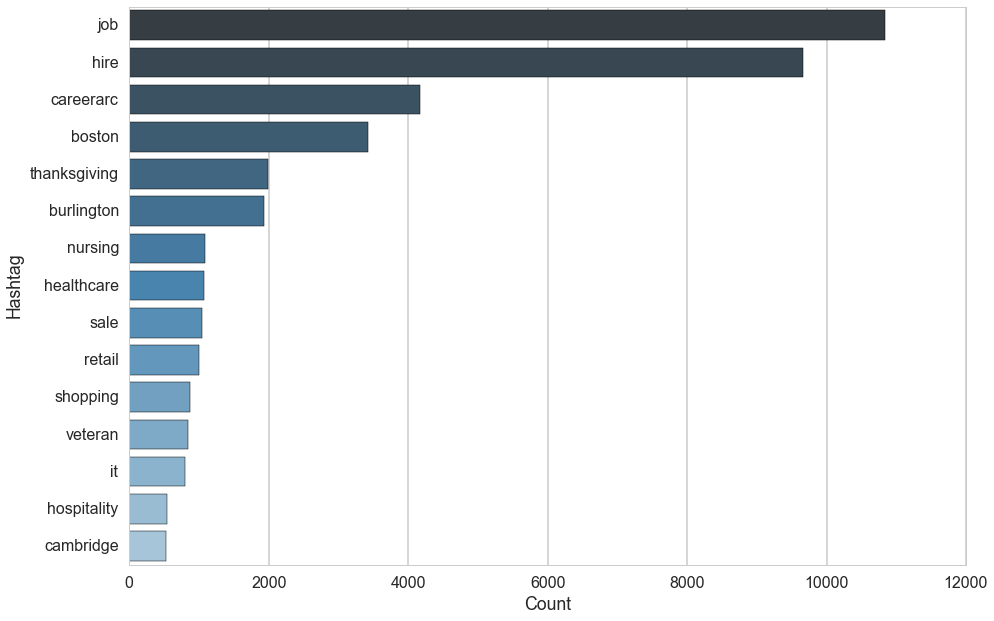

In [108]:
plt.figure(figsize=(15,10))  
sns.barplot(x='count', y='hashtag', data=hashcount_plot[:15], palette="Blues_d")
plt.xlabel("Count")
plt.ylabel("Hashtag")

In [ ]:
#extract hashtags
# subdf=dftokens_spark['s_hashtags'].flatMap(lambda l:l[2])
# hashtags=subdf.map(lambda w: (w,1)).reduceByKey(lambda a,b: a+b)
# hashtags.takeOrdered(10,key = lambda x: -x[1])

In [500]:
print "How many tweets have hash tags?", dftokens.map(lambda l:l[4]).reduce(lambda a,b:a+b)
print "How many tweets have emoji?", dftokens.map(lambda l:l[3]).reduce(lambda a,b:a+b)

How many tweets have hash tags? 258
How many tweets have emoji? 8


Since hashtags may contain more than one word, we do XXXX? In addition, some words may have different spellings, such as Thanksgiving v.s. thxgiving. We XXX the hashtags and find that around XXX of topics. 

In [3]:
#clean hashtags

After cleaning the hashtags, we can plot the of tweets for the top XXX topics over time, and we can also compare the top XXX topics of the locals and visitors.

In [4]:
#plot - all tweets

In [ ]:
#plot - by location

In addition, we take a look at the distribution of the users by looking at the number of its followers, friends, and statuses per year. We find out that XXXX. We define active users as users that have more than xxx followers, xx friends, or XXX statuses per year. 

In [ ]:
#identify users vs active users.

We also compare the topics discussed by active users v.s. less active users.

In [ ]:
#plot - users v.s. active users.

One thing we need to keep in mind is that tweets are usually very short, which sometimes do not capture anything that is substantial. Thus, we compare the number of tweets at each length over time.

In [7]:
#tweets length analysis

After the exploratory analysis, we find there are XXX topics discuss during the thanksgiving period. 

#Analysis

### Natural Language processing

Our next step is to take the text of the tweets and process this text to extract grammar and semantic meaning from it.

The tweets language is very informal, which makes parsing very hard. We made XXX. In general ,we still use the very standard sentence parsing techniques from `pattern` to help use identify noun and adjectives.

**Note that many tweets have hashtags, we remove these contents and only keep texts of a tweet.**

We will use a simialr function as `get_parts` from homework 5 to get the nouns of the text.

We create a list of what we consider punctuation below, and obtain our stopwords from the `sklearn` stopwords list.

In [81]:
from pattern.en import parse
from pattern.en import pprint
from pattern.vector import stem, PORTER, LEMMA
punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')

In [82]:
from sklearn.feature_extraction import text 
stopwords=text.ENGLISH_STOP_WORDS

#### Parsing language

We compile two regular expressions we will use. The first matched two or more dots in an ellipsis, while the second matches too or more dashes. We'll assume a single dot is a sentence separator while an single dash means a hyphenated word which is important to keep.

In [83]:
import re
regex1=re.compile(r"\.{2,}")
regex2=re.compile(r"\-{2,}")

The function get_parts below takes in an input tweet and returns a tuple of nouns and adjectives. Each member of the tuple is a list of lists. For instance the first member is a list, whose members are lists of nouns. Each such member is mined from a sentence. Some sentences will not have any representation as they dont pass the battery of conditions we impose below. Indeed if any sentence has no adjectives or no nouns we remove it. The idea eventually is to treat each such sentence as a tweet, with the nouns used to find the topic (using LDA), and the adjectives used to do sentiment analysis (via Naive Bayes).

`get_parts` does the following:

- First we substitute anything more than two dots or two dashes by a space so the letters on either side are treated as separate words
- Then we use pattern to parse the text into sentences. The sentences are tokenized into words, and lemmatized, which means that we convert words into their basic form, for [example](https://github.com/piskvorky/topic_modeling_tutorial/blob/master/1%20-%20Streamed%20Corpora.ipynb):

> "work", "working", "works", "worked", "working" => same lemma: "work"

- The words are associated with tags from the [Penn Treebank](http://www.clips.ua.ac.be/pages/mbsp-tags) in the parse process. This enables us to identify parts-of-speech.

In [84]:
def get_parts(thetext):
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    nouns=[]
    descriptives=[]
    for i,sentence in enumerate(parse(thetext, tokenize=True, lemmata=True).split()):
        nouns.append([])
        descriptives.append([])
        for token in sentence:
            #print token
            if len(token[4]) >0:
                if token[1] in ['JJ', 'JJR', 'JJS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    descriptives[i].append(token[4])
                elif token[1] in ['NN', 'NNS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    nouns[i].append(token[4])
    out=zip(nouns, descriptives)
    nouns2=[]
    descriptives2=[]
    for n,d in out:
        if len(n)!=0 and len(d)!=0:
            nouns2.append(n)
            descriptives2.append(d)
    return nouns2, descriptives2

#### Run `get_parts` on the `text` column of the dataframe

In [85]:
tweet_parts = dftokens_spark.map(lambda x: get_parts(x.text))

We'll take the first three to see what our code looks like.

In [86]:
tweet_parts.take(3)

[([], []),
 ([[u'mood']], [[u'bad']]),
 ([[u'age', u'adult']], [[u'appropriate']])]

We use collect to collect in a python list all of our results. 

In [87]:
%%time
parseout=tweet_parts.collect()

CPU times: user 2.79 s, sys: 7.53 s, total: 10.3 s
Wall time: 10min 1s


##Topic Analysis

###Batch Variation Bayes for LDA
This LDA is a more advanced model according to http://www.cs.princeton.edu/~blei/papers/HoffmanBleiBach2010b.pdf

Some of the codes are excerpted from an open source LDA algorithm https://github.com/qpleple/online-lda-vb/tree/master/mdhoffma 

In [1]:
import sys, re, time, string
import numpy as n
from scipy.special import gammaln, psi

n.random.seed(100000001)
meanchangethresh = 0.001

We used an online variational Bayes algorithm for latent Dirichlet allocation (LDA), one of the simplest topic models and one on which many others are based. This algorithm is based on online stochastic optimization, which has been shown to produce good parameter estimates dramatically faster than batch algorithms on large datasets. Online LDA handily analyzes massive collections of documents and, moreover, online LDA need not locally store or collect the documents— each can arrive in a stream and be discarded after one look, although we are doing it locally 

Latent Dirichlet Allocation (LDA) is a Bayesian probabilistic model of text documents. It assumes a collection of K “topics.” Each topic defines a multinomial distribution over the vocabulary and is assumed to have been drawn from a Dirichlet, $\beta_k$ ~ Dirichlet($\eta$). Given the topics, LDA assumes the following generative process for each document (**d**). First, draw a distribution over topics $\theta_d$ ∼ Dirichlet($\alpha$). Then, for each word **i** in the document, draw a topic index $z_{di}$ ∈ {1, . . . , K} from the topic weights $z_{di}$ ∼ $\theta_d$ and draw the observed word wdi from the selected topic, $w_di$ ∼ $\beta_{z_{di}}$ .

For simplicity, the paper assumes symmetric priors on $\theta$ and $\beta$, but this assumption is easy to relax. Note that if we sum over the topic assignments $z$, then we get p($w_{di}$|$\theta_d$, $\beta$) = $\sum_k \theta_{dk} \beta_{kw}$.This leads to the “multinomial PCA” interpretation of LDA; we can think of LDA as a probabilistic factorization of the matrix of word counts **n** (where $n_{dw}$ is the number of times word $w$ appears in document $d$) into a matrix of topic weights $\theta$ and a dictionary of topics $\beta$. This algorithm can thus be seen as an extension of online matrix factorization techniques that optimize squared error to more general probabilistic formulations.

This algorithm can analyze a corpus of documents with LDA by examining the **posterior distribution** of the
topics $\beta$, topic proportions $\theta$, and topic assignments $z$ conditioned on the documents. This reveals latent structure in the collection that can be used for prediction or data exploration. This posterior cannot be computed directly, and is usually approximated using **Markov Chain Monte Carlo (MCMC)** methods or variational inference. Both classes of methods are effective, but both present significant computational challenges in the face of massive data sets. To this end, this algorithm develops online variational inference for LDA, an approximate posterior inference algorithm that can analyze massive collections of documents. It first review the traditional variational Bayes algorithm for LDA and its objective function, then present our online method, and show that it converges to a stationary point of the same objective function.

####Algorithm Procedures: Batch Variation Bayes for LDA
    

<br>Initialize $\lambda$ randomly
<br>**while** relative improvements in $L$($w, \phi, \gamma, \lambda$) > 0.00001 **do**:
<ul>$E$ step:
<br>**for** $d$ = 1 to D **do**:
<br><ul>Initialize $\gamma_{dk}$ = 1. (The constant 1 is arbitrary.)
<br>**repeat**:
<br><ul>Set $\phi \propto$ exp{$E_q$[log$\theta_{dk}$] + $E_q$[log$\beta_{kw}$]}
<br>Set $\gamma_{dk} = \alpha + \sum_w\phi_{dwk}n_{dw}$
</ul> **until** $\frac{1}{K}\sum_k$|change in $\gamma_{dk}$|<0.00001
<br></ul> **end for** <br>  *M step:* <br> Set $\lambda_{kw} = \eta + \sum_dn_{dw}\phi_{dwk}$<br></ul> **end while**


In [3]:
def dirichlet_expectation(alpha):
    if (len(alpha.shape) == 1):
        return(psi(alpha) - psi(n.sum(alpha)))
    return(psi(alpha) - psi(n.sum(alpha, 1))[:, n.newaxis])

In [12]:
def parse_doc_list(docs, vocab):
    """
    Parse a document into a list of word ids and a list of counts,
    or parse a set of documents into two lists of lists of word ids
    and counts.
    Arguments: 
    docs:  List of D documents. Each document must be represented as
           a single string. (Word order is unimportant.) Any
           words not in the vocabulary will be ignored.
    vocab: Dictionary mapping from words to integer ids.
    Returns a pair of lists of lists. 
    The first, wordids, says what vocabulary tokens are present in
    each document. wordids[i][j] gives the jth unique token present in
    document i. (Don't count on these tokens being in any particular
    order.)
    The second, wordcts, says how many times each vocabulary token is
    present. wordcts[i][j] is the number of times that the token given
    by wordids[i][j] appears in document i.
    """
    if (type(docs).__name__ == 'str'):
        temp = list()
        temp.append(docs)
        docs = temp

    D = len(docs)
    
    wordids = list()
    wordcts = list()
    for d in range(0, D):
        docs[d] = docs[d].lower()
        docs[d] = re.sub(r'-', ' ', docs[d])
        docs[d] = re.sub(r'[^a-z ]', '', docs[d])
        docs[d] = re.sub(r' +', ' ', docs[d])
        words = string.split(docs[d])
        ddict = dict()
        for word in words:
            if (word in vocab):
                wordtoken = vocab[word]
                if (not wordtoken in ddict):
                    ddict[wordtoken] = 0
                ddict[wordtoken] += 1
        wordids.append(ddict.keys())
        wordcts.append(ddict.values())

    return((wordids, wordcts))

In [10]:
class OnlineLDA:
    """
    Implements online VB for LDA as described in (Hoffman et al. 2010).
    """

    def __init__(self, vocab, K, D, alpha, eta, tau0, kappa):
        """
        Arguments:
        K: Number of topics
        vocab: A set of words to recognize. When analyzing documents, any word
           not in this set will be ignored.
        D: Total number of documents in the population. For a fixed corpus,
           this is the size of the corpus. In the truly online setting, this
           can be an estimate of the maximum number of documents that
           could ever be seen.
        alpha: Hyperparameter for prior on weight vectors theta
        eta: Hyperparameter for prior on topics beta
        tau0: A (positive) learning parameter that downweights early iterations
        kappa: Learning rate: exponential decay rate---should be between
             (0.5, 1.0] to guarantee asymptotic convergence.

        Note that if you pass the same set of D documents in every time and
        set kappa=0 this class can also be used to do batch VB.
        """
        self._vocab = dict()
        for word in vocab:
            #word = word.lower()
            #word = re.sub(r'[^a-z]', '', word)
            self._vocab[word] = len(self._vocab)

        self._K = K
        self._W = len(self._vocab)
        self._D = D
        self._alpha = alpha
        self._eta = eta
        self._tau0 = tau0 + 1
        self._kappa = kappa
        self._updatect = 0

        # Initialize the variational distribution q(beta|lambda)
        self._lambda = 1*n.random.gamma(100., 1./100., (self._K, self._W))
        self._Elogbeta = dirichlet_expectation(self._lambda)
        self._expElogbeta = n.exp(self._Elogbeta)

    def do_e_step(self, docs):
        """
        Given a mini-batch of documents, estimates the parameters
        gamma controlling the variational distribution over the topic
        weights for each document in the mini-batch.

        Arguments:
        docs:  List of D documents. Each document must be represented
               as a string. (Word order is unimportant.) Any
               words not in the vocabulary will be ignored.

        Returns a tuple containing the estimated values of gamma,
        as well as sufficient statistics needed to update lambda.
        """
        # This is to handle the case where someone just hands us a single
        # document, not in a list.
        if (type(docs).__name__ == 'string'):
            temp = list()
            temp.append(docs)
            docs = temp

        (wordids, wordcts) = parse_doc_list(docs, self._vocab)
        batchD = len(docs)

        # Initialize the variational distribution q(theta|gamma) for
        # the mini-batch
        gamma = 1*n.random.gamma(100., 1./100., (batchD, self._K))
        Elogtheta = dirichlet_expectation(gamma)
        expElogtheta = n.exp(Elogtheta)

        sstats = n.zeros(self._lambda.shape)
        # Now, for each document d update that document's gamma and phi
        it = 0
        meanchange = 0
        for d in range(0, batchD):
            # These are mostly just shorthand (but might help cache locality)
            ids = wordids[d]
            cts = wordcts[d]
            gammad = gamma[d, :]
            Elogthetad = Elogtheta[d, :]
            expElogthetad = expElogtheta[d, :]
            expElogbetad = self._expElogbeta[:, ids]
            # The optimal phi_{dwk} is proportional to 
            # expElogthetad_k * expElogbetad_w. phinorm is the normalizer.
            phinorm = n.dot(expElogthetad, expElogbetad) + 1e-100
            # Iterate between gamma and phi until convergence
            for it in range(0, 100):
                lastgamma = gammad
                # We represent phi implicitly to save memory and time.
                # Substituting the value of the optimal phi back into
                # the update for gamma gives this update. Cf. Lee&Seung 2001.
                gammad = self._alpha + expElogthetad * \
                    n.dot(cts / phinorm, expElogbetad.T)
                Elogthetad = dirichlet_expectation(gammad)
                expElogthetad = n.exp(Elogthetad)
                phinorm = n.dot(expElogthetad, expElogbetad) + 1e-100
                # If gamma hasn't changed much, we're done.
                meanchange = n.mean(abs(gammad - lastgamma))
                if (meanchange < meanchangethresh):
                    break
            gamma[d, :] = gammad
            # Contribution of document d to the expected sufficient
            # statistics for the M step.
            sstats[:, ids] += n.outer(expElogthetad.T, cts/phinorm)

        # This step finishes computing the sufficient statistics for the
        # M step, so that
        # sstats[k, w] = \sum_d n_{dw} * phi_{dwk} 
        # = \sum_d n_{dw} * exp{Elogtheta_{dk} + Elogbeta_{kw}} / phinorm_{dw}.
        sstats = sstats * self._expElogbeta

        return((gamma, sstats))

    def update_lambda(self, docs):
        """
        First does an E step on the mini-batch given in wordids and
        wordcts, then uses the result of that E step to update the
        variational parameter matrix lambda.

        Arguments:
        docs:  List of D documents. Each document must be represented
               as a string. (Word order is unimportant.) Any
               words not in the vocabulary will be ignored.

        Returns gamma, the parameters to the variational distribution
        over the topic weights theta for the documents analyzed in this
        update.

        Also returns an estimate of the variational bound for the
        entire corpus for the OLD setting of lambda based on the
        documents passed in. This can be used as a (possibly very
        noisy) estimate of held-out likelihood.
        """

        # rhot will be between 0 and 1, and says how much to weight
        # the information we got from this mini-batch.
        rhot = pow(self._tau0 + self._updatect, -self._kappa)
        self._rhot = rhot
        # Do an E step to update gamma, phi | lambda for this
        # mini-batch. This also returns the information about phi that
        # we need to update lambda.
        (gamma, sstats) = self.do_e_step(docs)
        # Estimate held-out likelihood for current values of lambda.
        bound = self.approx_bound(docs, gamma)
        # Update lambda based on documents.
        self._lambda = self._lambda * (1-rhot) + \
            rhot * (self._eta + self._D * sstats / len(docs))
        self._Elogbeta = dirichlet_expectation(self._lambda)
        self._expElogbeta = n.exp(self._Elogbeta)
        self._updatect += 1

        return(gamma, bound)

    def approx_bound(self, docs, gamma):
        """
        Estimates the variational bound over *all documents* using only
        the documents passed in as "docs." gamma is the set of parameters
        to the variational distribution q(theta) corresponding to the
        set of documents passed in.

        The output of this function is going to be noisy, but can be
        useful for assessing convergence.
        """

        # This is to handle the case where someone just hands us a single
        # document, not in a list.
        if (type(docs).__name__ == 'string'):
            temp = list()
            temp.append(docs)
            docs = temp

        (wordids, wordcts) = parse_doc_list(docs, self._vocab)
        batchD = len(docs)

        score = 0
        Elogtheta = dirichlet_expectation(gamma)
        expElogtheta = n.exp(Elogtheta)

        # E[log p(docs | theta, beta)]
        for d in range(0, batchD):
            gammad = gamma[d, :]
            ids = wordids[d]
            cts = n.array(wordcts[d])
            phinorm = n.zeros(len(ids))
            for i in range(0, len(ids)):
                temp = Elogtheta[d, :] + self._Elogbeta[:, ids[i]]
                tmax = max(temp)
                phinorm[i] = n.log(sum(n.exp(temp - tmax))) + tmax
            score += n.sum(cts * phinorm)
#             oldphinorm = phinorm
#             phinorm = n.dot(expElogtheta[d, :], self._expElogbeta[:, ids])
#             print oldphinorm
#             print n.log(phinorm)
#             score += n.sum(cts * n.log(phinorm))

        # E[log p(theta | alpha) - log q(theta | gamma)]
        score += n.sum((self._alpha - gamma)*Elogtheta)
        score += n.sum(gammaln(gamma) - gammaln(self._alpha))
        score += sum(gammaln(self._alpha*self._K) - gammaln(n.sum(gamma, 1)))

        # Compensate for the subsampling of the population of documents
        score = score * self._D / len(docs)

        # E[log p(beta | eta) - log q (beta | lambda)]
        score = score + n.sum((self._eta-self._lambda)*self._Elogbeta)
        score = score + n.sum(gammaln(self._lambda) - gammaln(self._eta))
        score = score + n.sum(gammaln(self._eta*self._W) - 
                              gammaln(n.sum(self._lambda, 1)))

        return(score)

####Applying the tweets dataset on the Batch Variation Bayesian LDA

In [4]:
import xlrd
import numpy
import re  

1. tftokens.xls: Each row represents one tweet, including all the information needed

2. stop_word.txt: Each line is a stop word, a potentially unsubstantive word which should be filtered out before natural language processing

In [6]:
stop_word_list = []
file_name = 'raw_data/stop_word.txt'

file_ = open(file_name,'r')
line = file_.readlines()

for stopword in line:
    stop_word_list.append(stopword)
stop_word_list = [x.replace('\r\n',str()) for x in stop_word_list]


In [7]:
wb = xlrd.open_workbook('raw_data/dftokens.xls')
ws = wb.sheet_by_name('tweets')

In [8]:
vocab = []
docset = []
for row_idx in range(1, ws.nrows):
    tweet = unicode(ws.row_values(row_idx)[7]).encode("utf-8")        
    tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z '\t])|(\w+:\/\/\S+)"," ",tweet).split())    
    tmp = str()
    for word in tweet.split():
        if (word.lower() not in  stop_word_list) :
            tmp+=word.lower()
            tmp+=" "
            if (word.lower() not in  vocab) :
                vocab+=[word.lower()]
    if (tmp!=""):
        docset+=[tmp[:len(tmp)-1]]
#print docset

In [40]:
W = len(vocab)
D = len(docset)
batchsize = 64
documentstoanalyze = int(D/batchsize)
K = 5
olda_ingredient = OnlineLDA(vocab, K, D, 1./K, 1./K, 1024., 0.6)
n_pass = 1
for iteration in range(0, n_pass*documentstoanalyze):
    perm_indexes = numpy.random.permutation(range(D))[0:batchsize]
    sub_docset = []
    for idx in perm_indexes:
        sub_docset.append(docset[idx])
    # Give them to online LDA
    (gamma, bound) = olda_ingredient.update_lambda(sub_docset)
    # Compute an estimate of held-out perplexity
    (wordids, wordcts) = parse_doc_list(sub_docset, olda_ingredient._vocab)
    perwordbound = bound * len(sub_docset) / (D * sum(map(sum, wordcts)))
    #print '%d:  rho_t = %f,  held-out perplexity estimate = %f' % \
     #   (iteration, olda_ingredient._rhot, numpy.exp(-perwordbound))

In [41]:
#numpy.savetxt('lambda-ingredient-%d.txt' % iteration, olda_ingredient._lambda)
#numpy.savetxt('gamma-ingredient-%d.txt' % iteration, gamma)

num_elements = 10
testlambda = olda_ingredient._lambda
print len(testlambda[1])
for k in range(0, len(testlambda)):

    lambdak = list(testlambda[k, :])
    lambdak = lambdak / sum(lambdak)
    temp = zip(lambdak, range(0, len(lambdak)))
    temp = sorted(temp, key = lambda x: x[0], reverse=True)
    print 'topic %d:' % (k)
    # feel free to change the "53" here to whatever fits your screen nicely.
    for i in range(0, num_elements):
        print '%20s  \t---\t  %.4f' % (vocab[temp[i][1]], temp[i][0])

41303
topic 0:
                love  	---	  0.0276
              people  	---	  0.0152
                game  	---	  0.0133
                life  	---	  0.0106
                home  	---	  0.0103
             tonight  	---	  0.0084
               gonna  	---	  0.0072
                wait  	---	  0.0070
                stop  	---	  0.0060
                hope  	---	  0.0057
topic 1:
               today  	---	  0.0187
              boston  	---	  0.0102
                feel  	---	  0.0099
                shit  	---	  0.0079
             fucking  	---	  0.0078
                 god  	---	  0.0073
                hate  	---	  0.0067
               hours  	---	  0.0062
               watch  	---	  0.0060
                  st  	---	  0.0050
topic 2:
        thanksgiving  	---	  0.0351
                 amp  	---	  0.0332
               happy  	---	  0.0287
               night  	---	  0.0121
            thankful  	---	  0.0118
                  gt  	---	  0.0111
            tomorrow  	---	  0.

**Understanding The Result** :
<br> The above list gives us the most significant 5 topics people were discussing during the Thanksgiving break. 
<br> To interprete: 
<br><li> Topic 0: It is clearly related to the thanksgiving break, people are talking about family.
<br><li> Topic 1: People are showing a degree of anger, I guess this might be related to the lost game of Patriots.
<br><li> Topic 2: This is related to the thanksgiving night, people are talking positive words.
<br><li> Topic 3: This is a spamming account, which kept posting career hiring on twitter in Boston area.
<br><li> Topic 4: People are complaining about the end of the holiday because they have to go back to work/school

#REPLACE THIS CELL WITH INTERPRETATION OF ABOVE ANSWERS

###Unsupervised Topic Extraction with LDA

As we can see from the interpretation above, the **Batch Variation Bayes for LDA** generated pretty plausible result. However, WE WANT TO KNOW MORE! Instead of just knowing what top five topics of all the tweets gathered, we explore further to see whick topic each tweet belongs to. This requires mapping back the lda model to specific set of words and generate topic distribution. To do this, we switched our direction a bit by adopting the LDA method introdeced in *HW5* and added some helper function to reach our goal. In this section we will walk through the entire process from creating vocabulary to finding the best number of topics to LDA modeling and finally to topic mapping.

We want to find out what a particular sentence of a tweet talks about. We look at the nouns of the sentence to do this. The nouns are the first elements of all the tuples we created. We flatten the outer list which holds all the lists corresponding to one given tweet out, because we now want to treat each accepted sentence in a tweet as a separate mini-tweet.

The generative model for LDA is one in which a document comes from a mixture of topics. Each topic can be thought of as a cluster. We need some data which has very clear and strong cluster membership to clearly delineate the clusters. Thus we need to treat the text at a granularity where at-least some sentences have strong cluster membership. For a tweet, for example, some sentences may talk only about thanksgiving food, and some sentences may talk only about shopping, and its important to have these so that the topics (clusters) can be clearly established. Thus a sentence is a reasonable granularity, while a paragraph may be too big.

We use Spark's `flatMap` to do this.

In [88]:
ldadatardd=sc.parallelize([ele[0] for ele in parseout]).flatMap(lambda l: l)
ldadatardd.cache()
ldadatardd.take(5)

[[u'mood'], [u'age', u'adult'], [u'netflix'], [u'bit', u'amp'], [u'goody']]

#### Creating the vocabulary

We have a set of "documents" for the LDA, each corresponding to the nouns in a sentence in all the tweets, lets go about compiling the complete vocabulary that these documents use. We need to do this so that we can set up the documents in the form of a corpus, where each document is a sparse vector of the size of the vocabulary, with a number in the slot for the word indicating how many times that word appeared in a document.
So the first thing we want to do is to collect all the words. One more flattening does the job but will have duplicates

In [89]:
ldadatardd.flatMap(lambda word: word).take(15)

[u'mood',
 u'age',
 u'adult',
 u'netflix',
 u'bit',
 u'amp',
 u'goody',
 u'order',
 u'cheese',
 u'pizza',
 u'friend',
 u'cop',
 u'job',
 u'movie',
 u'hotel']

Then, in the usual word-count style we reduce to get the word numbers and then just drop these numbers as we dont care for them. We zipWithIndex the words to give them an index which we'll use as the place index in the corpus vector.

In [90]:
vocabtups = (ldadatardd.flatMap(lambda word: word)
             .map(lambda word: (word, 1))
             .reduceByKey(lambda a, b: a + b)
             .map(lambda (x,y): x)
             .zipWithIndex()
).cache()

We use Spark's collectAsMap to output the vocabulary vocab with the words as keys. We also use map to invert this dictionary and get id2word which maps the index to the word. This dictionary is then used by Gensim.

In [91]:
vocab=vocabtups.collectAsMap()
id2word=vocabtups.map(lambda (x,y): (y,x)).collectAsMap()

The size of our vocabulary:

In [92]:
len(vocab.keys())

25738

#### Create a Corpus in bag of words form

Now we create the lazy RDD `documents`.  `documents`  will be a list of lists that reflects the entire set of sentences. Each one of the member lists consists of a set of tuples `(index, count)` where `index` is the index of the corresponding word in the vocabulary and `count` is the number of times it occured in the sentence.

`documents` will look something like:

```
[[(5912, 1), (3809, 1), (14131, 1), (3876, 1)],
[(3266, 1), (3652, 1), (11644, 1), (2296, 1), (27516, 1), (8382, 1)],
 [(17217, 1), (22979, 1), (11210, 1), (18736, 1), (3893, 1), (21307, 1)],
 ...,
 [(23980, 1), (24730, 1), (22979, 1), (20012, 1), (11206, 2)]]
```

In [93]:
from collections import defaultdict
def constructDict(wordlist):
    result = defaultdict(int)
    for word in wordlist:
        result[word] += 1
    return list(result.iteritems())

documents = ldadatardd.map(lambda x: [vocab[i] for i in x]).map(lambda x: constructDict(x))


We `collect` and store in the variable `corpus`.

In [94]:
corpus=documents.collect()

We now run the LDA algorithm on the nouns only. The nouns typically reflect the themes of a tweet sentence and including other parts of speech adds noise.

We'll explore different number of topics, since the tweets are collected without theme bias, and they should intuitivly belong to different topics. However, out wish is there are at least two specific kind of topics generated: *thanksgiving reunion* and *thanksgiving shopping*, since the data is collected before, during and after thanksgiving holidays and it is our intuition to study thanksgiving's influence on tweets. Of course there will be some mixing and such. The decision is rarely ever completely clean.

Remember that LDA is an unsupervised algorithm, so there is no "performance" to measure. But we would like the two clusters we are looking for to correspond to our intuition that one should cover the thanksgiving reunion (including food) and one the another qualities of the shopping. Or something similar.

But again remember that there is no reason that this intuition is correct. Since these clusters are "latent" factors. But if they do coincide with topics/classes/clusters in our data, LDA is more useful.

We run LDA using a method called "variational inference", which can be updated online. We run it in chunks of 20,000 documents, hoping that topics have converged by then. This makes subsequent training faster.

####Finding the natural number of topics for Latent Dirichlet Allocationopics to fit the LDA Model.

Frequently, setting the parameter for the number of topics is treated as ‘an art’. However, Arun et al2 have put forward a process for finding the natural number of topics through matrix factorisation. After seeing a few requests for an implementation of this, we coded up a way to do it with gensim library for Python and combine the result with empirical evidence to decide the number of topics. 

The HDP mixture model is a natural nonparametric generalization of Latent Dirichlet allocation, where the number of topics can be unbounded and learnt from data. Here each group is a document consisting of a bag of words, each cluster is a topic, and each document is a mixture of topics. The HDP is also a core component of the infinite hidden Markov model, which is a nonparametric generalization of the hidden Markov model allowing the number of states to be unbounded and learnt from data.

The HDP module encapsulates functionality for the online Hierarchical Dirichlet Process algorithm. It allows both model estimation from a training corpus and inference of topic distribution on new, unseen documents.

In [96]:
from gensim import models
hdp = models.HdpModel(corpus = corpus, id2word = id2word)

Since in HDP model the number of topics can be unbounded and learnt from data, we print out the top 10 topics:

In [104]:
hdp_topics = hdp.print_topics(10)
for i in hdp_topics:
    print i + '\n'


topic 0: 0.005*gt + 0.003*job + 0.002*temperature + 0.002*humidity + 0.002*pressure + 0.001*amp + 0.001*wind + 0.001*day + 0.001*person + 0.001*time + 0.001*fit + 0.001*thing + 0.001*game + 0.001*thanksgiving + 0.001*year + 0.001*today + 0.001*friend + 0.001*thank + 0.001*sale + 0.001*love

topic 1: 0.003*job + 0.002*amp + 0.001*time + 0.001*person + 0.001*day + 0.001*year + 0.001*fit + 0.001*thanksgiving + 0.001*today + 0.001*game + 0.001*friend + 0.001*family + 0.001*guy + 0.001*thank + 0.001*thing + 0.001*sale + 0.001*shit + 0.001*life + 0.001*click + 0.000*monday

topic 2: 0.003*job + 0.001*amp + 0.001*person + 0.001*day + 0.001*time + 0.001*today + 0.001*fit + 0.001*thanksgiving + 0.001*friend + 0.001*year + 0.001*thing + 0.001*family + 0.001*thank + 0.001*man + 0.001*sale + 0.001*life + 0.001*shit + 0.001*game + 0.001*click + 0.000*night

topic 3: 0.003*job + 0.001*amp + 0.001*person + 0.001*day + 0.001*time + 0.001*thanksgiving + 0.001*fit + 0.001*today + 0.001*year + 0.001*thin

Judging from the output, we see the topics don't change much after 5, moreover, the fisrt part of our LDA with 5 topics generate pretty plausible results. Thus we choose **topic number = 5** for all the following LDA analysis.

In [135]:
import gensim
lda5 = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = 5, update_every=1, chunksize=20000, passes=1)

####LDA Topic Interpretation

Since LDA is a generative model, each time the trained topics are different. To further explore the hidden facts of tweeter data during Thanksgiving, we need to make sure the topics stays consistant during the following analysis. To do this, we record one of our topic result and use it for all following analysis.

<img src='lda_topic.png' width=1200 height=480/>

In [144]:
for bow in corpus[0:900:15]:
    print bow
    print lda5.get_document_topics(bow)
    print " ".join([id2word[e[0]] for e in bow])
    print "=========================================="

[(5472, 1)]
[(0, 0.10006687545166193), (1, 0.10000533582381226), (2, 0.10000623540961709), (3, 0.10000032165475944), (4, 0.59992123166014932)]
mood
[(22974, 1), (23787, 1), (23205, 1), (15246, 1), (24511, 1)]
[(0, 0.033921422514835917), (1, 0.033615633887405474), (2, 0.034281566867042028), (3, 0.033622057891006314), (4, 0.86455931883971038)]
soup dad mom nana chicken
[(3136, 1), (12064, 1), (15267, 1), (18096, 1)]
[(0, 0.041352982270339331), (1, 0.61924087555777951), (2, 0.25863080060204624), (3, 0.040335192359154705), (4, 0.040440149210680135)]
men woman family days-sec
[(19666, 1)]
[(0, 0.1000836573635538), (1, 0.10008552975175984), (2, 0.59965823544452601), (3, 0.10008795960278898), (4, 0.10008461783737146)]
t_is_superman
[(5984, 1), (8227, 1), (10461, 1), (2271, 1)]
[(0, 0.8359459707413146), (1, 0.04260062673999257), (2, 0.040720489199689992), (3, 0.040540751533521678), (4, 0.040192161785481219)]
folk rail transit amp
[(23002, 1), (10309, 1)]
[(0, 0.39788628762615436), (1, 0.400944

We create a new dataframe **topicRef** to store the the topic indices and their corresponding bag of words.

In [138]:
topic_index = []
topic_BoW = []
for i in lda5.print_topics():
    topic_index.append(i[0])
    topic_BoW.append(i[1])

topicRef = pd.DataFrame({'topic_index':topic_index, 'topic_BoW': topic_BoW})

In [142]:
topicRef

,topic_BoW,topic_index
0,0.161*job + 0.050*fit + 0.039*time + 0.034*sal...,0
1,0.038*year + 0.025*shit + 0.024*birthday + 0.0...,1
2,0.042*face + 0.039*amp + 0.033*tear + 0.021*gu...,2
3,0.054*day + 0.040*today + 0.026*thanksgiving +...,3
4,0.061*person + 0.021*friend + 0.016*love + 0.0...,4


With **topicRef**, we are able to interprete what each topic means:

**Topic 0: ** 
* Keyword: *Sale*
* Bag of words: sale, click, life, thing, thank...

**Topic 1: ** 
* Keyword: *Patriots* (People complaining about the loss of Patriots during thanksgiving week)
* Bag of words: game, hour, ass, year, shit, man...

**Topic 2: ** 
* Keyword: *Other*
* Bag of words: face, tear, guy, night, world...

**Topic 3: ** 
* Keyword: *Family*
* Bag of words: family, home, team, school, tonight...

**Topic 4: ** 
* Keyword: *Holiday*
* Bag of words: friend, love, girl, food, holiday...

We then add an column named 'Keyword' to **topicRef** to label the theme of the tweet. We also create an dictionary that maps the topic index and keyword for future reference.

In [153]:
topicRef['Keyword'] = ['Sale', 'Patriots', 'Other', 'Family', 'Holiday']
topicRef

,topic_BoW,topic_index,Keyword
0,0.161*job + 0.050*fit + 0.039*time + 0.034*sal...,0,Sale
1,0.038*year + 0.025*shit + 0.024*birthday + 0.0...,1,Patriots
2,0.042*face + 0.039*amp + 0.033*tear + 0.021*gu...,2,Other
3,0.054*day + 0.040*today + 0.026*thanksgiving +...,3,Family
4,0.061*person + 0.021*friend + 0.016*love + 0.0...,4,Holiday


In [156]:
topic_keyword = dict(zip(topicRef.topic_index, topicRef.Keyword))
topic_keyword

{0: 'Sale', 1: 'Patriots', 2: 'Other', 3: 'Family', 4: 'Holiday'}

####Map the topic of each tweet 

Now that we have trained and compared models with different number of topics, and based on the analysis above, we decide to use lda5 for our next step: classifying the topic each tweet belongs to and getting the classifying confidence.

We define function *getTweetTopic* to get take the cleaned tweet text as input and generate its Topic. Here we simply take the topic with highest probabality from the topics set.

In [121]:
"""
Function
--------
getTweetTopic

Get the topic index given the cleaned tweet text.

Parameters
----------
tweet_text : a list of tokens of a tweet.
lda_model: the LDA model adopted to make classifications
returnType: decide whether to return the topic index or the confidence, 0 for index, 1 for confidence

Output
----------
the topic index or the confidence of classification of the input tweet

"""

def getTweetTopic(tweet_text, lda_model, returnType = 0):
    words = tweet_text.split(' ')
    words_idx = []
    for i in words:
        if i in vocab.keys():
            words_idx.append(vocab[i])
    topics = lda_model.get_document_topics(constructDict(words_idx))
    topics.sort(key=lambda x: x[1], reverse = True)
    
    if returnType == 0:
        return topics[0][0]
    else:
        return topics[0][1]

Apply getTweetTopic to the cleaned_text in dftokens dataframe to get the topic index of each tweet, and create a new column named *'Topic'* in dftokens. We use spark to accelerate the process.

In [118]:
dftokens_spark = sqlsc.createDataFrame(dftokens)

In [122]:
topics = dftokens_spark.map(lambda x: getTweetTopic(x.cleaned_text, lda5, 0))

In [154]:
%time
topics = topics.collect()

In [157]:
dftokens = pd.read_csv('raw_data/dfsentiment.csv')

In [159]:
dftokens['Topic'] = topics
dftokens['Topic_keyword'] = dftokens.Topics.apply(lambda x: topic_keyword[x])

Now **dftokens** has both sentiment and topic labels:

In [160]:
dftokens.head()

,index,user_id,date,time,tweet_longitude,tweet_latitude,tweet_id,text,followers_count,friends_count,statuses_count,created_at_u,truncated,quoted_text,in_reply_to_status_id,retweeted_status,timestamp_ms,lang,country,place_full_name,sent,quoted,s_clean,s_tokens,s_emo,s_hashtags,q_clean,q_tokens,q_emo,q_hashtags,cleaned_text,sentiment,Topics,Topic,Topic_keyword
0,0,3095695629,2015-11-23,14:06:44,-71.683502,42.036932,668868299040665603,@DopeAhhAquarius lemme come over bro :(,7424,985,36984,Thu Mar 19 01:33:34 +0000 2015,False,NaN,6.688680e+17,False,1.448306e+12,en,United States,"Massachusetts, USA","( lemme come over bro , [lemme, come, over, br...",NaN,lemme come over bro,"[lemme, come, over, bro]",[:(],[],NaN,NaN,NaN,NaN,lemme come over bro,0,1,PythonRDD[28] at collect at <ipython-input-123...,Patriots
1,1,2174756318,2015-11-23,14:06:44,-71.326858,42.636248,668868299116138496,I've been in a bad mood since like 2010,110,159,2199,Mon Nov 04 21:06:33 +0000 2013,False,NaN,0.000000e+00,False,1.448306e+12,en,United States,"Lowell, MA","(I've been in a bad mood since like 2010, [i'v...",NaN,I've been in a bad mood since like 2010,"[i've, been, in, a, bad, mood, since, like, 2010]",[],[],NaN,NaN,NaN,NaN,I've been in a bad mood since like 2010,0,2,PythonRDD[28] at collect at <ipython-input-123...,Other
2,2,408976087,2015-11-23,14:06:46,-71.088755,42.313670,668868309526429697,what's the appropriate age for me to start act...,514,246,37162,Thu Nov 10 03:50:52 +0000 2011,False,NaN,0.000000e+00,False,1.448306e+12,en,United States,"Boston, MA",(what's the appropriate age for me to start ac...,NaN,what's the appropriate age for me to start act...,"[what's, the, appropriate, age, for, me, to, s...",[],[],NaN,NaN,NaN,NaN,what's the appropriate age for me to start act...,1,0,PythonRDD[28] at collect at <ipython-input-123...,Sale
3,3,1163319366,2015-11-23,14:06:52,-71.312617,42.693109,668868335573012480,@JackSillin @AlexReedWX @WesternMEwx ...I assu...,465,604,57037,Sat Feb 09 16:02:36 +0000 2013,False,NaN,6.688683e+17,False,1.448306e+12,en,United States,"Dracut, MA","( I assume your dad works at your school?), ...",NaN,I assume your dad works at your school?),"[i, assume, your, dad, works, at, your, school...",[],[],NaN,NaN,NaN,NaN,I assume your dad works at your school?),1,2,PythonRDD[28] at collect at <ipython-input-123...,Other
4,6,107886768,2015-11-23,14:06:55,-96.307306,65.838115,668868346813771776,"@kady I'm watching River (BBC) on netflix, I t...",961,1198,85936,Sun Jan 24 03:02:09 +0000 2010,False,NaN,0.000000e+00,False,1.448306e+12,en,Canada,Canada,"( I'm watching River (BBC) on netflix, I think...",NaN,"I'm watching River (BBC) on netflix, I think ...","[i'm, watching, river, (, bbc, ), on, netflix,...",[],[],NaN,NaN,NaN,NaN,"I'm watching River (BBC) on netflix, I think ...",0,3,PythonRDD[28] at collect at <ipython-input-123...,Family


In [161]:
dftokens.to_csv("raw_data/dftokens.csv", index = False, encoding='utf-8')

###Exploratory analysis for LDA

Add graphs here...

##Sentiment Analysis

We want to analyze the sentiment of each tweet. However, it is not an easy task. In genearl, there are three approaches that we can measure the sentiment:

1. identify words used in a tweet that are positive or negative, and then compute the ratio of positive words to total number of opinioned words.

2. manually label a set of tweets, and conduct supervised machine learning algorithims, such as KNN or Naive Bayes classifiers.

3. use existent sentiment analysis packages, such as `sentiment` from `pattern`.

Each approach has its pros and cons. The first approach is straight forward but may only achieve relative low accuracy. The second approach may impove the accuracy, but it requires us to go through a fair amount of tweets and decide whether they are positive or negative. The accuracy relies on how well these tweets are classified, which is not an easy tasks and requires expertise in linguistics. The third approach is the easiest. However, we cannot tune parameters, and we do not know whether the mechanics behind works well for tweets, which are quite different from formal languages. 

Constrained by the amount of time we have, we decide to start with first approach and then compare its result with the result of third approach.
Each approach has its pros and cons. The first approach is straight forward but may only achieve relative low accuracy. The secoEach approach has its pros and cons. The first approach is straight forward but may only achieve relative low accuracy. The second approach may impove the accuracy, but it requires us to go through a fair amount of tweets and decide whether they are positive or negative. The accuracy relies on how well these tweets are classified, which is not an easy tasks and requires expertise in linguistics. The third approach is the easiest. However, we cannot tune parameters, and we do not know whether the mechanics behind works well for tweets, which are quite different from formal languages. 


###Sentiment Analysis using Word Match

We find a list of positive and negative words that have been used in many opinion mining and senitment analysis [papers](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#datasets). 

The list of positive and negative words has around 6800 words and is quite comprehensive.

In [44]:
import nltk;
from nltk.stem.snowball import SnowballStemmer;
stemmer = SnowballStemmer("english");

In [45]:
#reading in positive words
f = open('raw_data/positive-words.txt','r');
poslist = set([]);
for line in f:
    line = line.strip();
    # print "Original: %s" %(line);
    line = stemmer.stem(line);
    # print "After Stemming: %s" %(line);
    poslist |= set([line]);
f.close;

In [46]:
#reading in negative words
neglist = set([]);
f = open('raw_data/negative-words.txt','r');
for line in f:
    line = line.strip();
    #print "Original: %s" %(line);
    line = stemmer.stem(line);
    # print "After Stemming: %s" %(line);
    neglist |= set([line]);
f.close;


We use the `SnowballStemmer` method from `nltk` package to find sterm of a word. 

Then, we match the sterm of words in a tweet with words in negative or positive word list, and calculate the occurence of positive and negative words. If there is a positive word, then we add 1 to sentiment value of the tweet. If there is a negative word, then we substract 1 from total value. At the end, we compute the ratio of sentiment value to total occurences of positive or negative words as the sentiment of the tweet. Thus, the sentiment of a tweet range from -1 to 1.  

If a tweet does not have any matched positive or negative words, we assume it is neutral and will get a 0 value.

In [47]:
#https://github.com/ravikiranj/twitter-sentiment-analyzer/blob/master/simpleDemo.py

#people sometimes like to type a word with a lot of repetitions.
def replaceTwoOrMore(s):
    #look for 2 or more repetitions of character
    pattern = re.compile(r"(.)\1{1,}", re.DOTALL) 
    return pattern.sub(r"\1\1", s)

In [50]:
"""
Function
--------
wordmatch

match tokens of a tweet with positive or negative words, and 
calculate the sentiment of the tweet.

Parameters
----------
textlist : a list of tokens of a tweet.

Output
----------
a list of reformatted hashtags
"""

def wordmatch(tokenlist,pos,neg):
    tokens= tokenlist[1:-1].replace("'","").split(", ")
    tokens = [replaceTwoOrMore(word) for word in tokens];
    tokens = [word.strip("#") for word in tokens if word not in stopwords];
    tokens = [stemmer.stem(word.decode('utf-8')) for word in tokens if word not in punctuation];
    pos_count = [1 for word in tokens if word in pos];
    neg_count = [-1 for word in tokens if word in neg];
    count=len(pos_count)+len(neg_count)
    total=np.float(np.sum(pos_count)+np.sum(neg_count))
    if count == 0.0:
        return 0
    else:
        return total/count


In [51]:
subdftokens=dftokens[['user_id','timestamp','s_clean','s_tokens','s_emo','q_clean','q_tokens','q_emo']]
senti=subdftokens.apply(lambda r:wordmatch(r.s_tokens,poslist,neglist),axis=1)
#subdftokens['s_senti']=subdftokens['s_tokens'].apply(lambda r:wordmatch(r,poslist2,neglist2))

(array([ 20790.,     76.,   1170.,   3386.,    585.,  50186.,   5594.,
          1838.,    880.,  53891.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

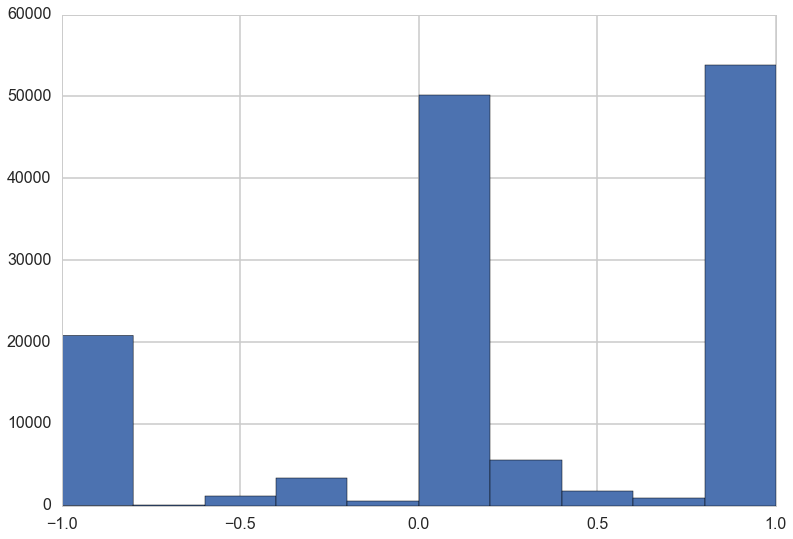

In [52]:
plt.hist(senti)

It seems that roughly half of the tweets are positive and half of them are neutral. 

However, is the positive or negative words list enough for tweets sentimental analysis? 

Not necessarily. Twitter language is like text message, and people tend to use abbreviations. We found a list of common abbreviations on this [website](http://www.illumasolutions.com/omg-plz-lol-idk-idc-btw-brb-jk.htm). Then, we pick some common abbreviations that indicate one's emotions/attitude, and add them to our positive and negative words list.

In [53]:
#positive abbreviations
textlangpos =['lol','lmao','lmfao','tff','rofl']
#negative abbreviations
textlangneg = ['stfu','pita','eol']

poslist2=poslist.union(textlangpos)
neglist2=neglist.union(textlangneg)

(array([ 20198.,     77.,   1170.,   3420.,    598.,  49380.,   5809.,
          1912.,    920.,  54912.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

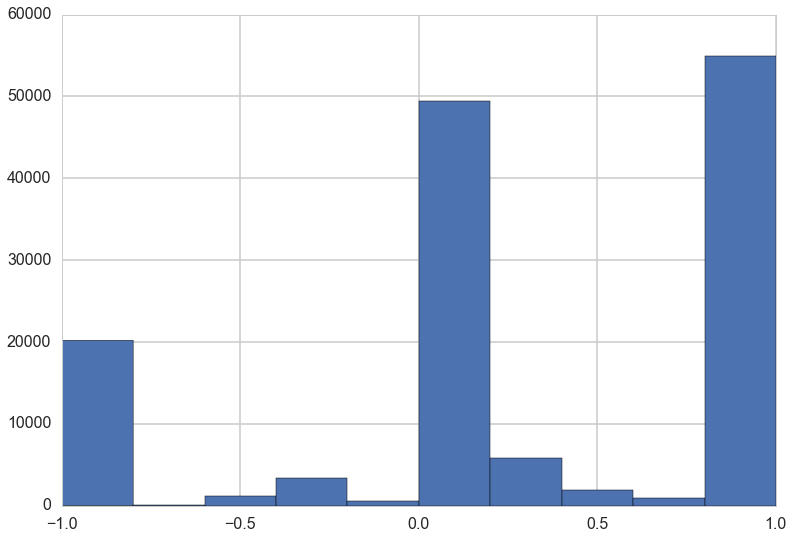

In [54]:
senti2=subdftokens.apply(lambda r:wordmatch(r.s_tokens,poslist2,neglist2),axis=1)
plt.hist(senti2)

In [55]:
print "Total Sentiment Shift:",np.sum(senti2-senti)
print "Average Sentiment Shift:",np.mean(senti2-senti)

Total Sentiment Shift: 1728.05
Average Sentiment Shift: 0.0124862712795


In [56]:
subdftokens['s_senti']=subdftokens['s_tokens'].apply(lambda r:wordmatch(r,poslist2,neglist2))

/Users/Jing/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Take a look at some tweets and their estimated sentiment. We did a good job for simple tweets, such as 'happy birthday brotha #osuforlife'. However, when a tweet has both positive and negative words, `wordmatch` did poorly. For example, the tweet, "It's very hard for me to trust on people's words," gets a sentiment value of 0. 

At the same time, we also notice that we was not able to take out all the emoticons. 

In [57]:
subdftokens[['s_clean','s_senti','s_emo']]

,s_clean,s_senti,s_emo
0,lemme come over bro,1.000000,[:(]
1,I've been in a bad mood since like 2010,0.000000,[]
2,what's the appropriate age for me to start act...,1.000000,[]
3,I assume your dad works at your school?),1.000000,[]
4,"I'm watching River (BBC) on netflix, I think ...",0.000000,[]
5,baby take a look at what you've done,0.000000,[]
6,LOUDLY CRYING FACE.FACE WITH TEARS OF JOY. Lmf...,-0.333333,[]
7,"No, seasons change, people don't",1.000000,[]
8,Have you picked out your #ThanksgivingWine?\n ...,1.000000,[]
9,"Listen, I love cheese. I do. But if you order ...",0.600000,[]


####Comparing Sentiment Results with Emoji used in Text

Since people use emoticons to express their emotions, we decide to conduct a sentiment analysis on emoticons as well

In [58]:
#define the emoticons that represent positive, negative, and neutral emotions.

pos_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]] # Mouth
    )"""

neg_str =r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [\(\[] # Mouth
    )"""

neutral_str =r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [/\\OpP] # Mouth
    )"""


neutral_re= re.compile(r'^'+neutral_str+'$', re.VERBOSE | re.IGNORECASE)
neg_re= re.compile(r'^'+neg_str+'$', re.VERBOSE | re.IGNORECASE)
pos_re= re.compile(r'^'+pos_str+'$', re.VERBOSE | re.IGNORECASE)



def proccessemo(text):
    
    if len(text)>2:
        emoticons=text[1:-1].replace("'","").split(", ")
        pos=[1 for emo in emoticons if pos_re.search(emo)]
        neg=[-1 for emo in emoticons if neg_re.search(emo)]
        neutral=[0 for emo in emoticons if neutral_re.search(emo)]
        count=len(pos)+len(neg)+len(neutral)
        total=np.float(np.sum(pos)+np.sum(neg)+np.sum(neutral))
        if count==0.0:
            return 0
        else:
            return total/count
    else:
        return None


In [59]:
subdftokens['s_emo_senti']=subdftokens['s_emo'].apply(lambda r: proccessemo(r))

/Users/Jing/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Total number of tweets that are compared: 2114
Average difference between Emoji Sentiment and Text Sentiment -0.217621750687
Standard error 0.834468514555


(array([ 109.,   25.,  524.,  131.,   25.,  953.,   29.,  243.,   18.,   57.]),
 array([-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <a list of 10 Patch objects>)

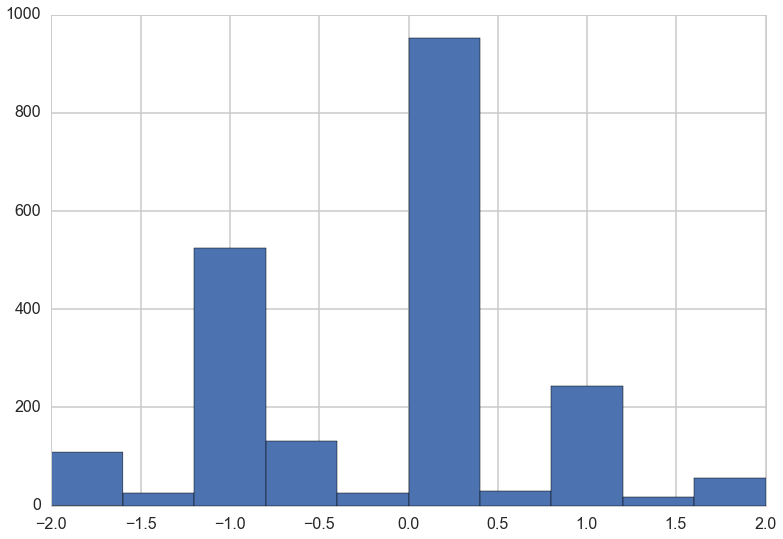

In [60]:
subdf=subdftokens[['s_clean','s_emo','s_senti','s_emo_senti']].dropna()
subdf['diff']=subdf.s_senti-subdf.s_emo_senti
print "Total number of tweets that are compared:", subdf.shape[0]
print "Average difference between Emoji Sentiment and Text Sentiment", np.mean(subdf['diff'])
print "Standard error", np.std(subdf['diff'])
plt.hist(subdf['diff'])

We are able to extract emoticons from 2113 tweets. 

1000 tweets' texts and emoticons express the sentiment. 

Another 1000 of tweets whose text and emoticons are telling different stories. After we take a closer look at these tweets, emoticons seen to provide more information about the sentiment of the tweets. Therefore, we decide to combined the sentiment score of texts and emotional score of emoticons. Since emoticons allow people to directly express their sentiment, we decide to place equal weight to sentiment of emoticons and sentiment of texts.

In [61]:
pd.set_option("display.max_colwidth",-1)

In [62]:
subdf[(subdf['diff']>=1) | (subdf['diff']<=-1)]

,s_clean,s_emo,s_senti,s_emo_senti,diff
0,lemme come over bro,[:(],1.000000,-1,2.000000
144,When u go to buy your first lottery ticket and they don't even ID you,[:(],0.000000,-1,1.000000
201,you need to see this,[:)],0.000000,1,-1.000000
228,"tiling is a solution to zooming too. You get a content scale. Or: when you zoom in, the content gets bigger",[;-)],0.000000,1,-1.000000
232,"Well, no but I did Rebecca",[:)],0.000000,1,-1.000000
412,I'm not just a Paige fan. I'm a fan of everyone.,[:P],1.000000,0,1.000000
561,If someone could suction off all my face fat that would be nice,[:)],0.000000,1,-1.000000
675,"I need to be in a team, but I'm way below y'alls tiers, I bet.",[:(],0.000000,-1,1.000000
803,how are u?,[:)],0.000000,1,-1.000000
861,please answer me,[:)],0.000000,1,-1.000000


In [63]:
def comb(r):
    if np.isnan(r.s_senti):
        if np.isnan(r.s_emo_senti):
            return None
        else:
            return r.s_emo_senti
    else:
        if np.isnan(r.s_emo_senti):
            return r.s_senti
        else:
            return 0.5*r.s_emo_senti+0.5*r.s_senti
        
subdftokens['s_comb']=subdftokens.apply(lambda r: comb(r),axis=1)


/Users/Jing/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(array([ 19997.,     83.,   1365.,   3407.,    612.,  49023.,   5709.,
          2443.,   1030.,  54727.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

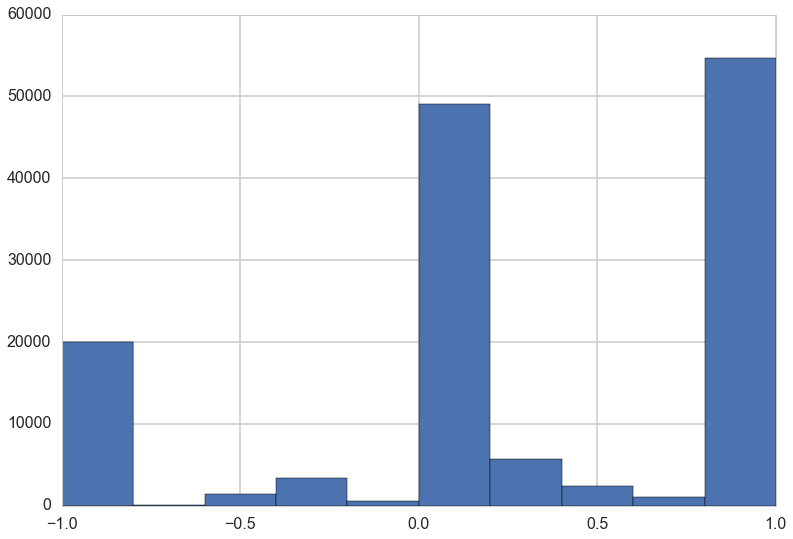

In [64]:
plt.hist(subdftokens['s_comb'])

Since some tweets have quoted text, we also looked at the sentiment of quoted text, and combine the score if it has emoticons.

In [65]:
def quote_senti(r):
    senti=wordmatch(r.q_tokens,poslist2,neglist2)
    emo_senti=proccessemo(r.q_emo)
    if emo_senti==None:
        return senti
    else:
        return 0.5*emo_senti + 0.5*senti


mask=subdftokens['q_clean'].isnull()
quotedf=subdftokens[~mask]
quotedf['q_comb']=quotedf.apply(lambda r:quote_senti(r),axis=1)    
    

/Users/Jing/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/Users/Jing/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


(array([  352.,   137.,  1652.,   328.,   277.,  3036.,   325.,  1643.,
          160.,   381.]),
 array([-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <a list of 10 Patch objects>)

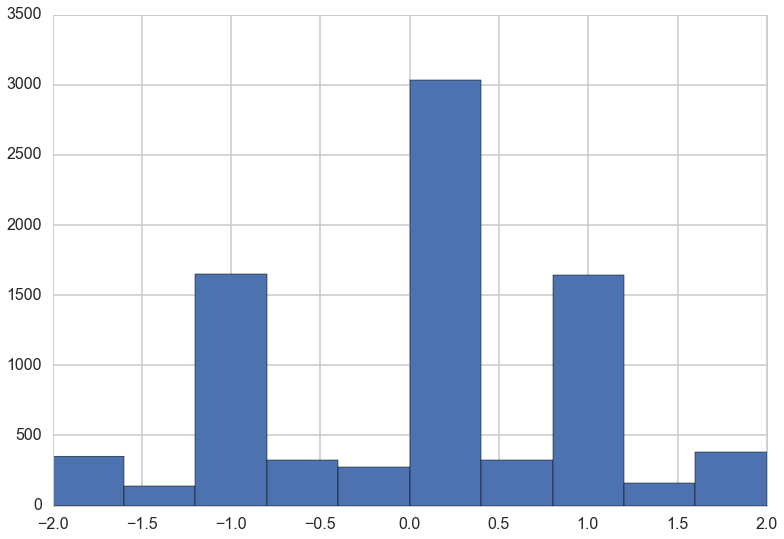

In [66]:
quotedf['diff']=quotedf['s_comb']-quotedf['q_comb']
plt.hist(quotedf['diff'].values)

In [67]:
quotedf[['s_clean','s_comb','q_clean','q_comb']][(quotedf['diff']<=-1) | (quotedf['diff']>=1) ]

,s_clean,s_comb,q_clean,q_comb
7,"No, seasons change, people don't",1.000000,"Love is rare, Life is strange, Nothing last, people change.",0
110,Used to be one of my favs,1.000000,Madeline (1993-2001),0
139,This is a must read.,0.000000,"Might want to keep this in mind when the next 12,300 polls come out.",1
147,"CRYING FACE., Boston needs more of this ,",-1.000000,#ChocolateWomenAppreciation,0
160,Low key baeeee. Like side bae or whatever,1.000000,he tells a joke and stares blankly and no one gets it then he laughs lmaoooo so quirky and adorable,0
247,The NFL is a joke.,-1.000000,"NFL statement on Rams' QB Case Keenum: ""Promptly after the conclusion of yesterday’s game, we began a review to",1
269,What?!?,0.000000,WR Aaron Dobson has been added to the injury report with a back injury. He is questionable for tonight’s game. #BUFvsNE,-1
308,Yeah i figured,0.000000,in the one I read though it said that those words aren't directly from his mouth though but from a close friend,1
375,Mitt would be ok I think. Honestly I do. But yah Palin was a DISASTER,0.000000,They gave us Bitch Romney in 2012 and Sarah Palin in 2008 as a VP. No.,-1
397,Can I help!!!!,1.000000,What dating app will I find myself a tall dark handsome man ?,0


After take a look at the quoted texts, we decide not to consider them when analyze texts. Sometimes texts agree with quoted texts, but sometimes they do not. Adding quoted texts would make the analysis more complicated but not necessarily more accurate.

###Sentiment Analysis using `Pattern`

The `sentiment` function from `pattern` package evaluate the sentiment of a sentence. Based on the adjectives a given sentence contains, the function returns a `(polarity,subjectivity)` tuple for the sentence. Here we are only interested in polarity, which is a value between -1.0 and +1.0: +1.0 being positive; -1.0 being negative.

The problem of using this function is that twitter language is very messy, and we do not know how well the function handle messy texts.

In [68]:
from pattern.en import sentiment
print sentiment("Breathe easy New England")

(0.28484848484848485, 0.6439393939393939)


In [69]:
subdftokens['s_senti_2'] = subdftokens['s_clean'].apply(lambda r: sentiment(r)[0])
subdftokens[['s_clean','s_senti','s_senti_2','s_comb']].head()

/Users/Jing/anaconda/lib/python2.7/site-packages/pattern/text/__init__.py:1943: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if w in imap(lambda e: e.lower(), e):
/Users/Jing/anaconda/lib/python2.7/site-packages/pattern/text/__init__.py:979: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  and tokens[j] in ("'", "\"", u"”", u"’", "...", ".", "!", "?", ")", EOS):
/Users/Jing/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,s_clean,s_senti,s_senti_2,s_comb
0,lemme come over bro,1,0.00,0
1,I've been in a bad mood since like 2010,0,-0.70,0
2,what's the appropriate age for me to start acting like an adult?,1,0.20,1
3,I assume your dad works at your school?),1,0.00,1
4,"I'm watching River (BBC) on netflix, I think you'd like it. A bit creepy &amp; really really well acted.",0,-0.15,0


In [70]:
subdftokens[['s_clean','s_senti','s_senti_2','s_comb']]\
[abs(subdftokens['s_senti']-subdftokens['s_senti_2'])>1]

,s_clean,s_senti,s_senti_2,s_comb
76,"Senior Agile Product Owner - Ericsson: (#Waltham, Massachusetts) #Job #Jobs #Hiring",1.000000,-0.125000,1.000000
90,"Customer Service Rep Phys - Lahey Health: (#Burlington, MA) #Clerical #Job #Jobs #Hiring",1.000000,-0.750000,1.000000
117,"FACE WITH TEARS OF JOY.Yoo so I went to the kitchen and I saw my 10 year old little sister watching your NBA video can you BELIVE that ,",1.000000,-0.043750,1.000000
121,"Clinical Project Managers/Sr Clinical Project Managers, - Quintiles: (#Boston, Massachusetts) #Pharmaceutical",1.000000,-0.750000,1.000000
136,Steven Gerrard to play for #Liverpool in January… in Legends game,1.000000,-0.400000,1.000000
147,"CRYING FACE., Boston needs more of this ,",-1.000000,0.150000,-1.000000
280,Just got yelled at by my boss for yelling vulgar things at bills fans in the hotel lobby #worthit,0.333333,-0.700000,0.333333
282,"HEAVY BLACK HEART.So thankful for ,️",1.000000,-0.183333,1.000000
288,"Manager Special Projects¸ Personal Insurance Benefits - Liberty Mutual Insurance: (#Boston, MA) #BusinessMgmt #Job",1.000000,-0.130952,1.000000
305,"Seriously? Seriously? Some people don't have enough to do or worry about. Absolute, mind-boggling stupidity.",-1.000000,0.091667,-1.000000


In [71]:
print "Total number of tweets:", subdftokens.shape[0]
mask=abs(subdftokens['s_senti']-subdftokens['s_senti_2'])>1
print "Number of tweets that have a sentiment differed by at least 1 measured by two methods:",subdftokens[mask].shape[0]

Total number of tweets: 138396
Number of tweets that have a sentiment differed by at least 1 measured by two methods: 6168


We conduct a paired two-sample t-test to test whether the difference of two methods is zero.

$H_0: \delta=0$ 

$H_A: \delta\neq0$

The t-value is : 98.8043279153
The calculate p-value is approximate to: 0.0


(array([    78.,    940.,  12286.,   9732.,  13603.,  50706.,  21782.,
         27912.,   1059.,    298.]),
 array([-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <a list of 10 Patch objects>)

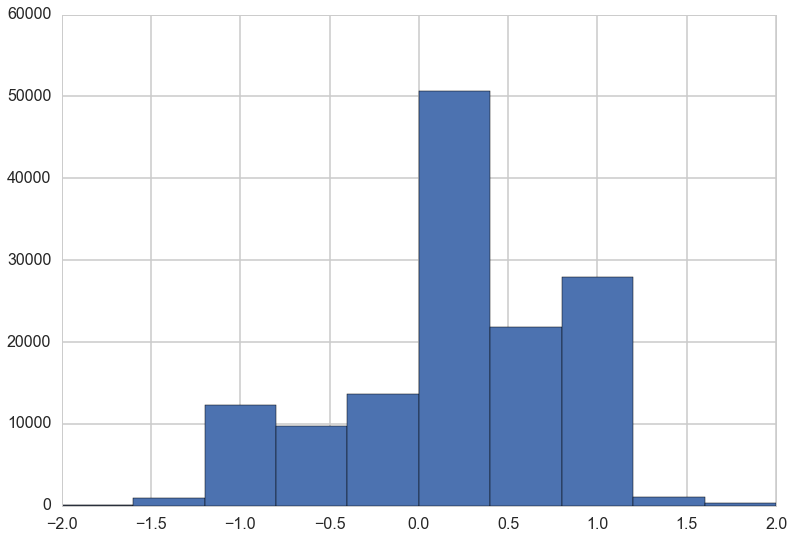

In [72]:
from scipy import stats
diff=subdftokens['s_senti'].values-subdftokens['s_senti_2'].values
t,p=stats.ttest_1samp(diff,0)
print "The t-value is :", t
print "The calculate p-value is approximate to:" ,p
plt.hist(diff)

Since the calulated p-value is less than 0.05, we reject the null hypothesis, and conclude that the result of two methods is different.

We also compare the `s_comb` and `s_senti_2`, and conclude that they are different.

The t-value is : 99.9780338326
The calculate p-value is approximate to: 0.0


(array([    78.,    940.,  12286.,   9732.,  13603.,  50706.,  21782.,
         27912.,   1059.,    298.]),
 array([-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <a list of 10 Patch objects>)

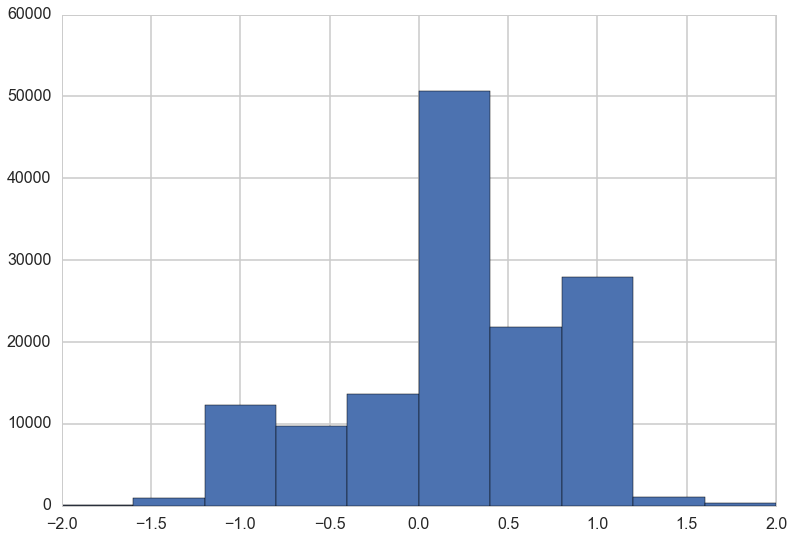

In [73]:
from scipy import stats
diff2=subdftokens['s_comb'].values-subdftokens['s_senti_2'].values
t,p=stats.ttest_1samp(diff2,0)
print "The t-value is :", t
print "The calculate p-value is approximate to:" ,p
plt.hist(diff)

Unfortunately, we do not know the sentiment of a tweet and cannot draw a conclusion on which method is better. By just going through tweets that rated differently by two methods, we find that sometimes `wordmatch` function gives a more reasonable sentiment score, while sometimes `sentiment` function gives a more reasonble score. Therefore, we decide to take the average of two methods as our final sentiment score for all tweets.